# Data SAO 158379

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

import scipy.special as sc
from scipy.interpolate import interp1d
from astropy import units as u
from skyfield.api import load
import pymc as pm
import arviz as az

import aesara
import aesara.tensor as at
from aesara.compile.ops import as_op
az.style.use("arviz-darkgrid")
# plt.style.use(['science', 'notebook', 'grid'])
pd.set_option('display.float_format',  '{:}'.format)

In [2]:
df = pd.read_csv("sao-158379.csv", sep=',')
df.head()

FrameNum         timeInfo  signal-target
0    2801.0  [12:56:56.9572]       417856.0
1    2802.0  [12:56:56.9773]       331218.0
2    2803.0  [12:56:56.9973]       382878.0
3    2804.0  [12:56:57.0174]       383219.0
4    2805.0  [12:56:57.0374]       373990.0

In [3]:
# hilangkan karakter [ dan ] dari data
df['timeInfo'] = df['timeInfo'].map((lambda x: x.lstrip('[').rstrip(']')))

# ubah ke format waktu dan ambil tanggal dan jamnya
df['timeInfo'] = pd.to_datetime(df['timeInfo'])

df.head()

FrameNum                   timeInfo  signal-target
0    2801.0 2022-08-02 12:56:56.957200       417856.0
1    2802.0 2022-08-02 12:56:56.977300       331218.0
2    2803.0 2022-08-02 12:56:56.997300       382878.0
3    2804.0 2022-08-02 12:56:57.017400       383219.0
4    2805.0 2022-08-02 12:56:57.037400       373990.0

In [4]:
data = df[['FrameNum','timeInfo','signal-target']]
data.columns = ['Frame','Time', 'Value']
data.head()

Frame                       Time    Value
0 2801.0 2022-08-02 12:56:56.957200 417856.0
1 2802.0 2022-08-02 12:56:56.977300 331218.0
2 2803.0 2022-08-02 12:56:56.997300 382878.0
3 2804.0 2022-08-02 12:56:57.017400 383219.0
4 2805.0 2022-08-02 12:56:57.037400 373990.0

In [5]:
data['JD'] = Time(data['Time']).jd

data['frac_JD'] = data['JD'] - np.floor(data['JD']).astype(int)
data

Frame                       Time    Value                 JD  \
0    2801.0 2022-08-02 12:56:56.957200 417856.0  2459794.039548116   
1    2802.0 2022-08-02 12:56:56.977300 331218.0  2459794.039548348   
2    2803.0 2022-08-02 12:56:56.997300 382878.0   2459794.03954858   
3    2804.0 2022-08-02 12:56:57.017400 383219.0 2459794.0395488124   
4    2805.0 2022-08-02 12:56:57.037400 373990.0  2459794.039549044   
...     ...                        ...      ...                ...   
1195 3996.0 2022-08-02 12:57:20.903500  15561.0  2459794.039825272   
1196 3997.0 2022-08-02 12:57:20.923500   -191.0 2459794.0398255032   
1197 3998.0 2022-08-02 12:57:20.943600  -2107.0  2459794.039825736   
1198 3999.0 2022-08-02 12:57:20.963600   5244.0 2459794.0398259675   
1199 4000.0 2022-08-02 12:57:20.983600   8405.0  2459794.039826199   

                  frac_JD  
0     0.03954811580479145  
1     0.03954834816977382  
2    0.039548580069094896  
3     0.03954881243407726  
4    0.039549043867737055  
...                   ...  
1195  0.03982527181506157  
1196  0.03982550324872136  
1197 0.039825736079365015  
1198  0.03982596751302481  
1199   0.0398261989466846  

[1200 rows x 5 columns]

In [6]:
# import matplotlib.dates as mdates

# fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(data['Time'], data['Value'], 'ro', alpha=0.5)
# #ax.plot(data['Frame'], data['Value'], 'ro', alpha=0.35)
# # ax.set_xlabel('UTC (mm:ss.ssssss)')
# #ax.set_xlim(3300, 3700)
# ax.set_xlabel('Frames')

# date_form = mdates.DateFormatter("%H:%M:%S")#, tz=pytz.timezone(‘Australia/Sydney’))
# #ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# #ax.xaxis.set_major_locator(mdates.HourLocator(byhour=None, interval=2))
# ax.xaxis.set_major_formatter(date_form)
# #ax.tick_params(‘x’, labelrotation=45)

# # data['Time'].dt.hour()

Text(0.5, 0, 'Frames')

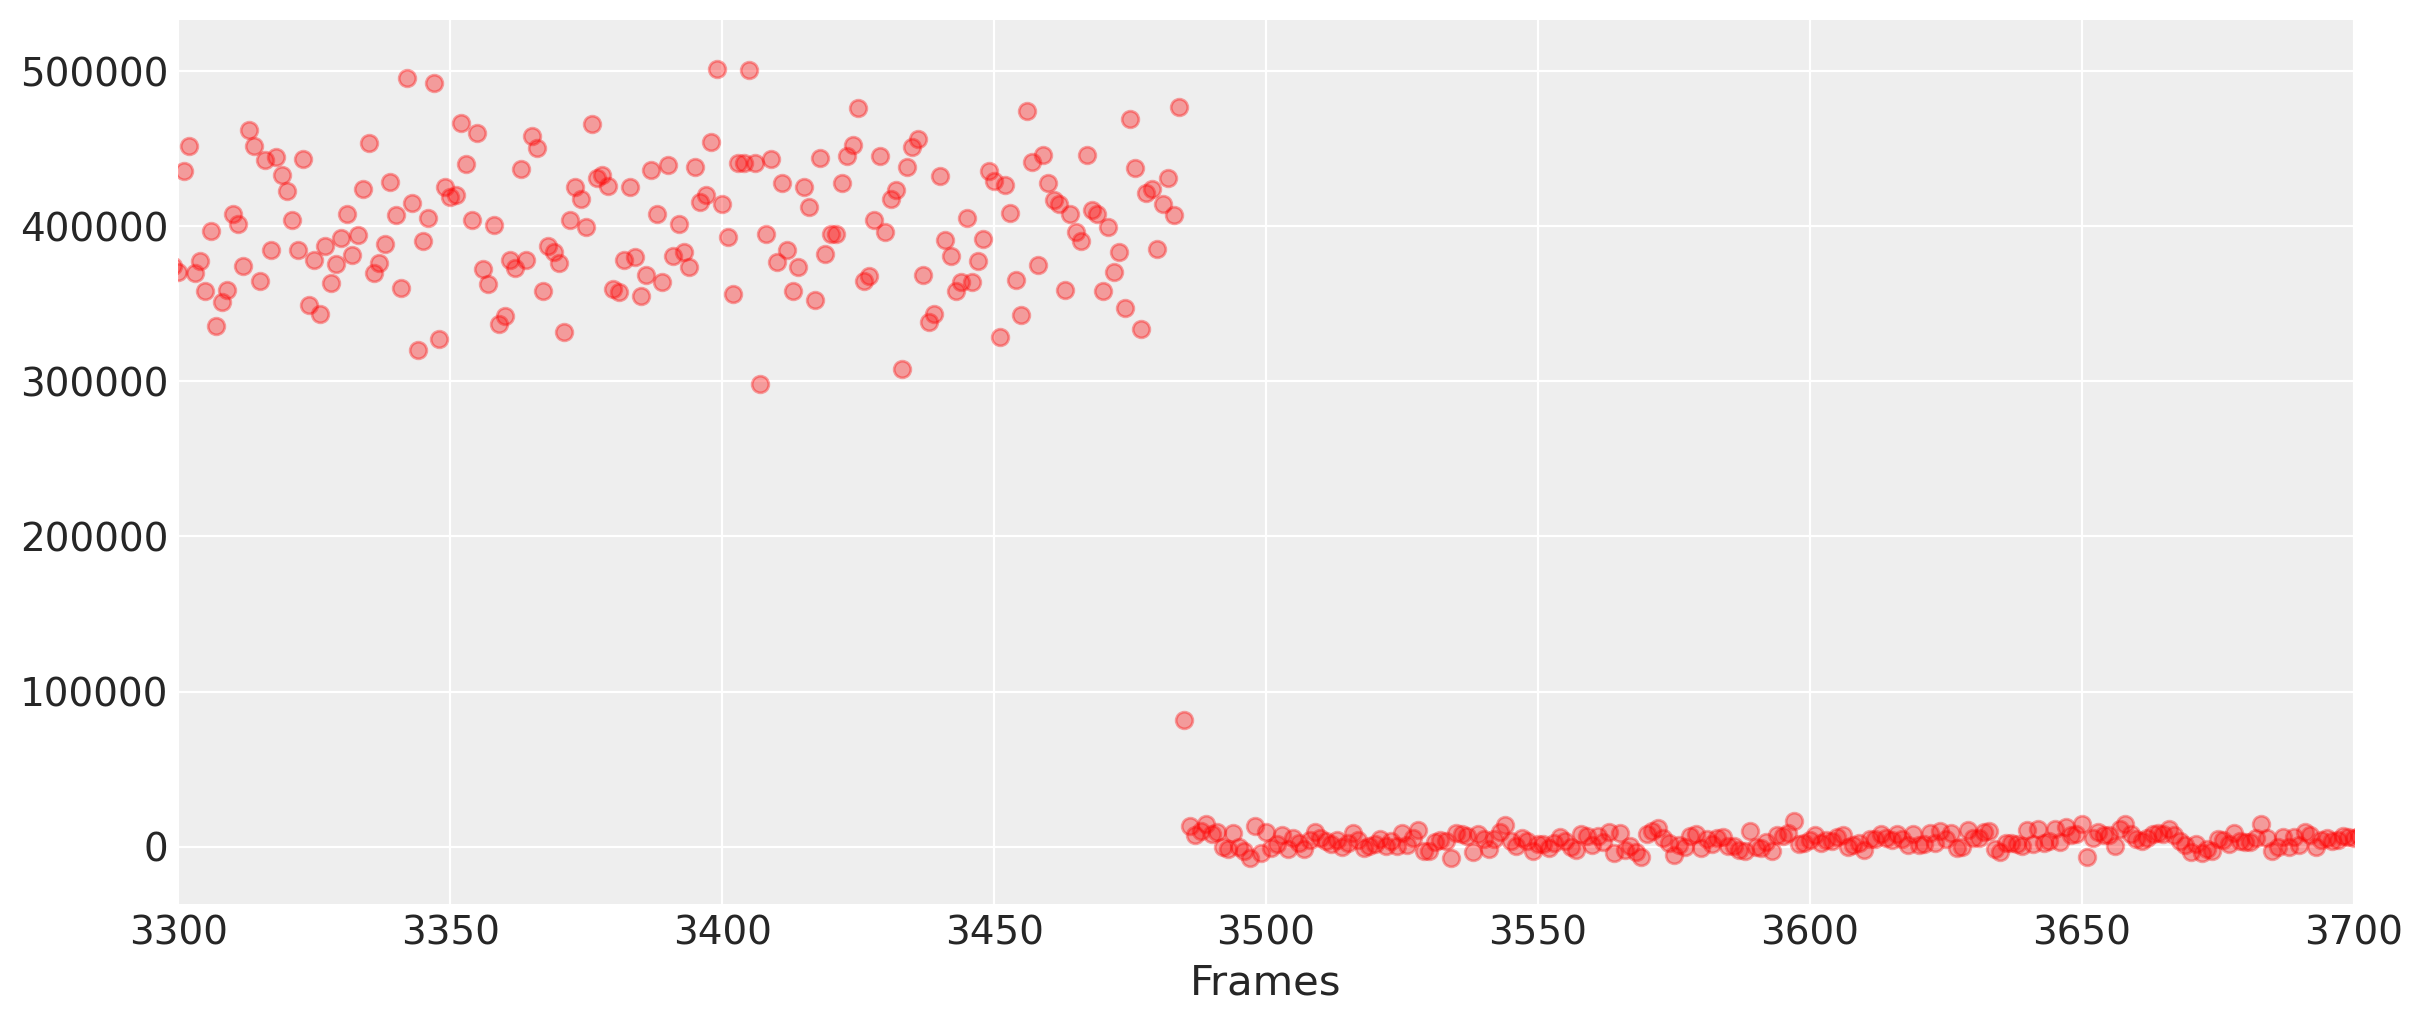

In [7]:
fig, ax = plt.subplots(figsize=(12,5))
# ax.plot(data['Time'], data['Value'], 'ro', alpha=0.5)
ax.plot(data['Frame'], data['Value'], 'ro', alpha=0.35)
# ax.set_xlabel('UTC (mm:ss.ssssss)')
ax.set_xlim(3300, 3700)
ax.set_xlabel('Frames')
# fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(data['frac_JD'], data['Value'], 'ro', alpha=0.5)
# ax.set_xlabel('Frac JD')

### Normalisasi Data

In [8]:
def Normalisasi(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) 

In [9]:
# value_scaled = Normalisasi(data['Value'])
value_scaled = data['Value']/(data['Value'].std()*2)

Text(0.5, 0, 'Frames')

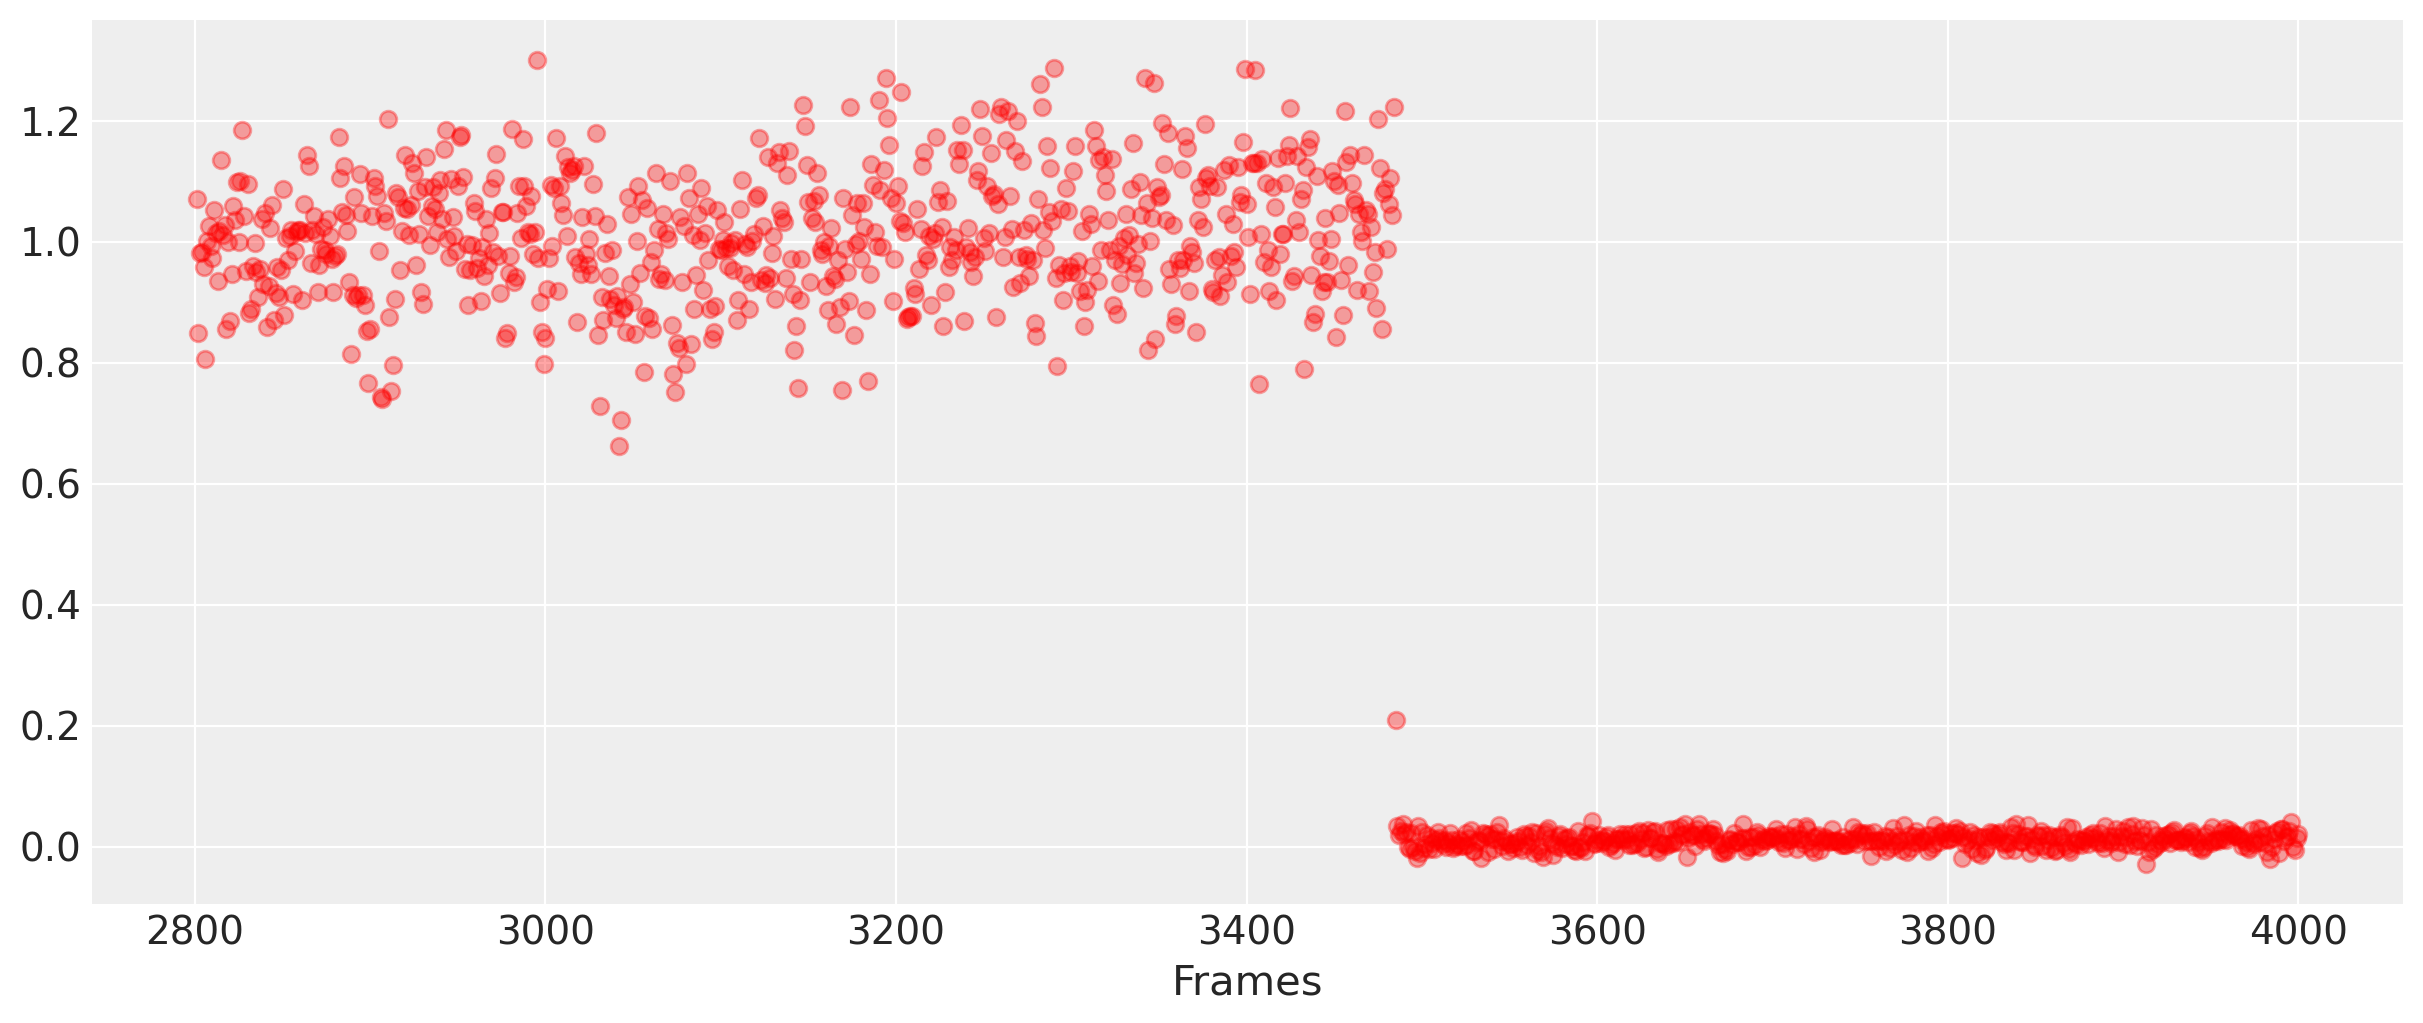

In [10]:
fig, ax = plt.subplots(figsize=(12,5))
# ax.plot(data['frac_JD'], value_scaled, 'ro', alpha=0.35)
ax.plot(data['Frame'], value_scaled, 'ro', alpha=0.35)
ax.set_xlabel('Frames')

### Kurva Benda Hitam untuk SAO 158379

#### Cari temperatur efektif

Temperatur efektif bintang bisa didekati dengan persamaan yang menghubungkan indeks warna bintang, $B - V$ dengan temperatur efektif bintang, $T_\mathrm{eff}$. Persamaan yang digunakan dalam pekerjaan ini diadopsi dari pekerjaan **Ballesteros 2012** (https://arxiv.org/pdf/1201.1809.pdf) sebagai berikut:

$$
T_\mathrm{eff} =  4600\left(\frac{1}{0.92 (B-V) + 1.7} + \frac{1}{0.92 (B-V) + 0.62} \right)
$$

In [11]:
# Satuan t_eff adalah Kelvin

def ballesteros(bv):
    return 4600. * ((1./(0.92*bv + 1.7)) + (1./(0.92*bv + 0.62)))

In [12]:
b = 6.95
v = 6.85

bv = b - v

teff = ballesteros(bv)
teff

9027.638443017651

In [13]:
def Planck(λ, T): 
    """
    λ: dalam cm
    T: dalam K
    """
    a = 3.7412e-5 / ((λ * 1e-7) **5) # 1e-7 adalah konversi dari nm ke cm
    b = np.exp(1.43879/(λ * 1e-7 * T)) - 1
    return a/b

In [14]:
x_axis = np.arange(100, 2000)

In [15]:
y_axis = Planck(x_axis, teff)

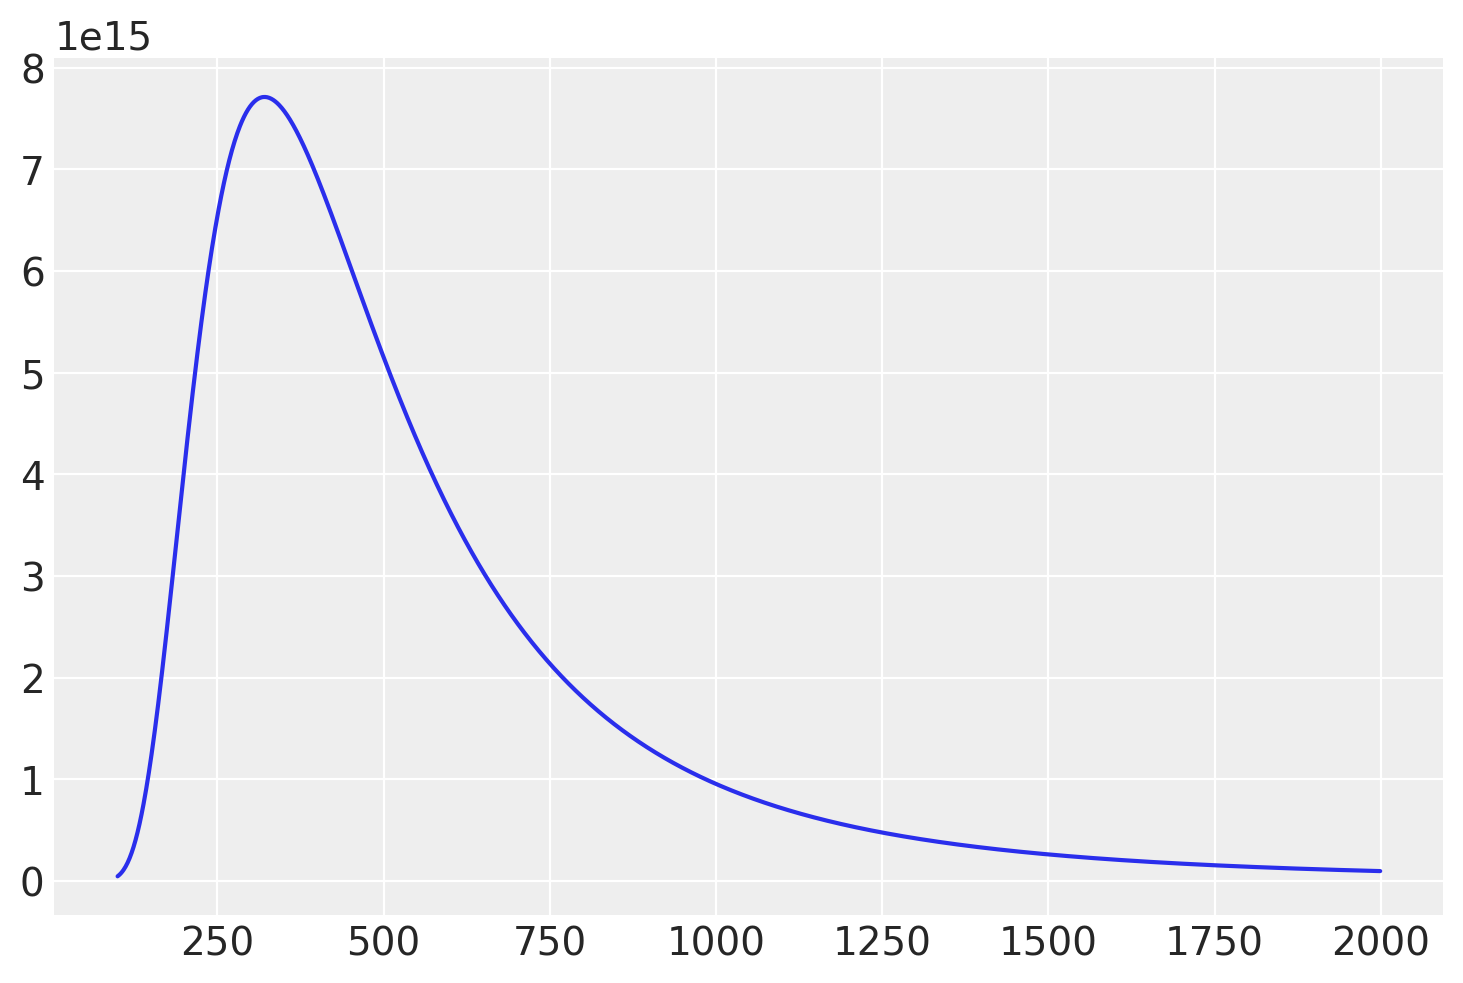

In [16]:
plt.plot(x_axis, y_axis)

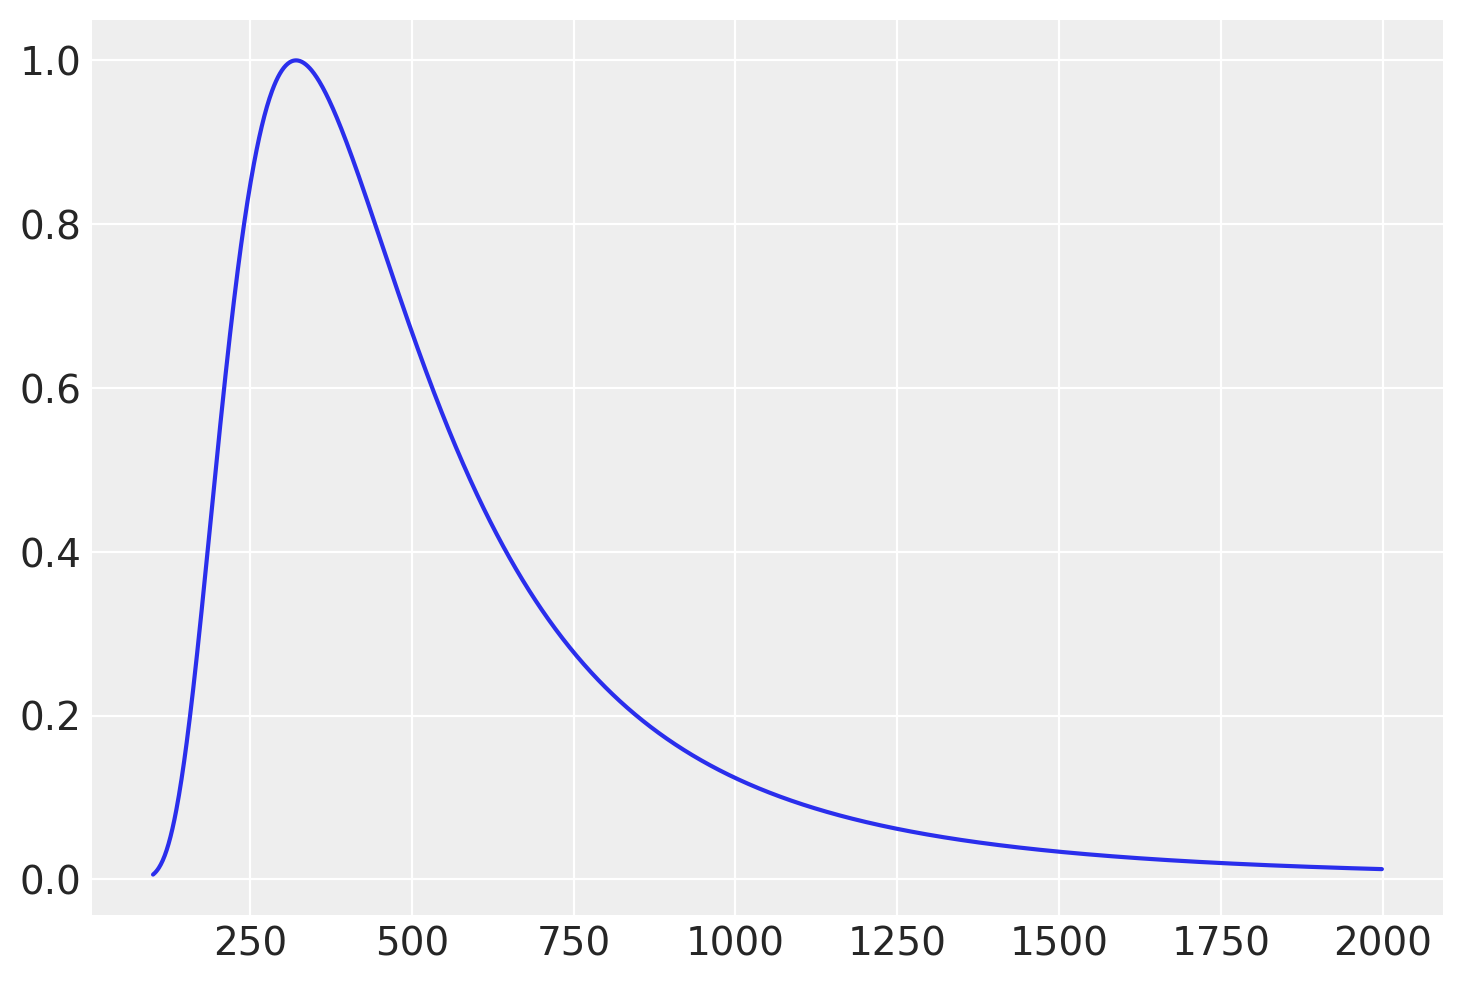

In [17]:
den = np.max(y_axis)

y_val = y_axis/den

plt.plot(x_axis, y_val)

### Kurva transmisi QHY 174M GPS *unfiltered*

In [18]:
df = pd.read_csv('qhy174_response.csv', delimiter=',', header='infer')
df.head()

wavelength  response
0       200.0       0.0
1       210.0       0.0
2       220.0       0.0
3       230.0       0.0
4       240.0       0.0

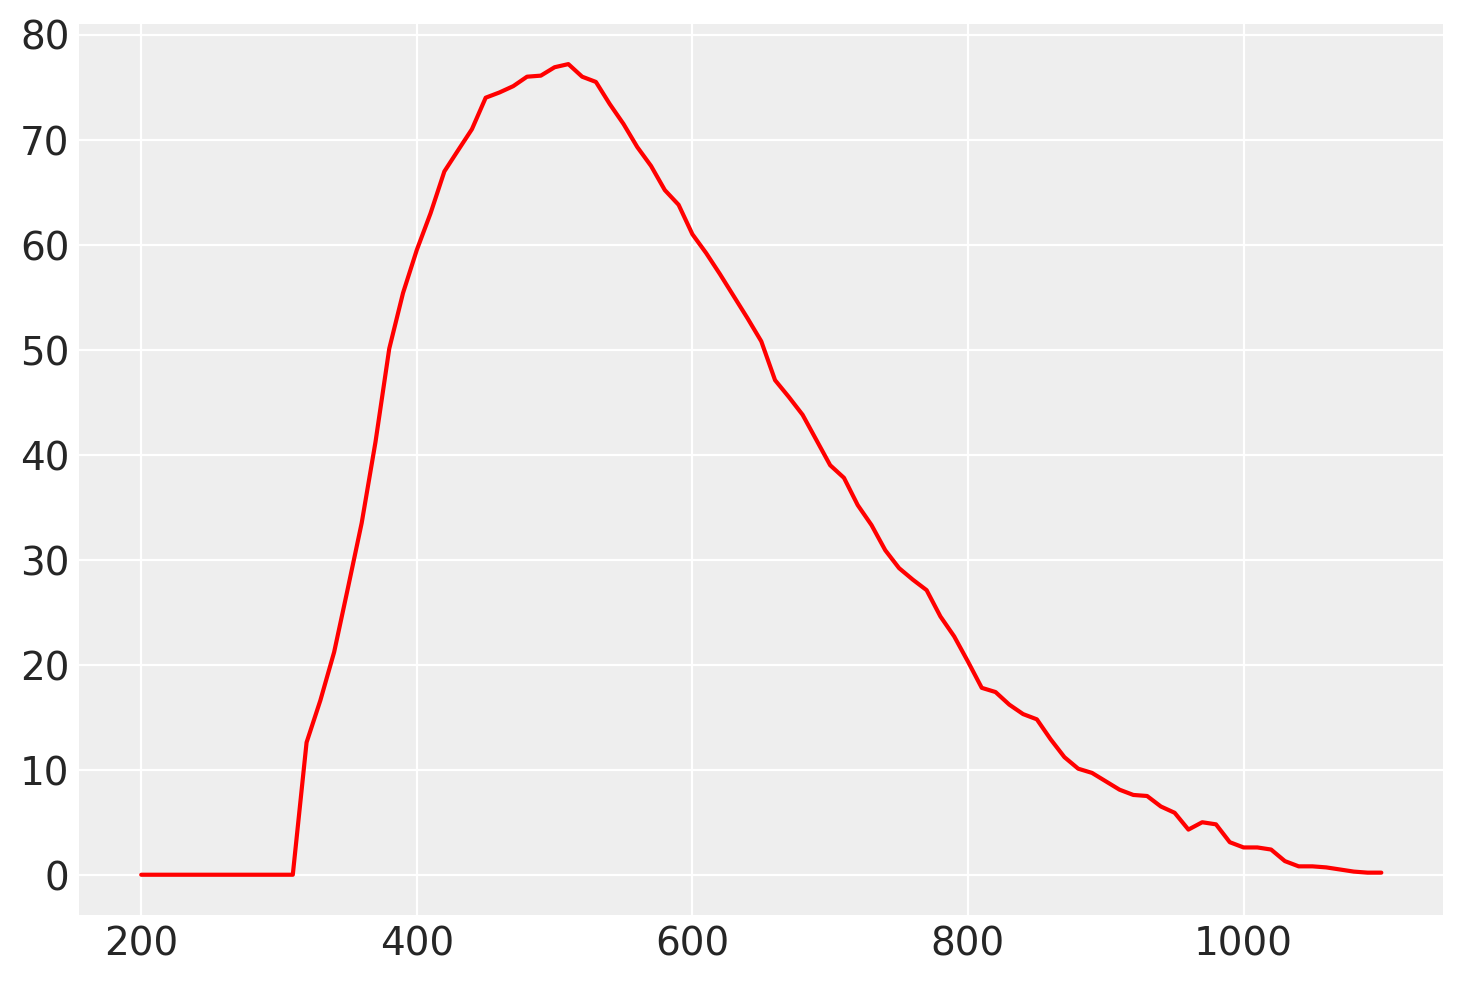

In [19]:
x = df['wavelength']
y = df['response']
plt.plot(x, y, 'r')

In [20]:
bandwidth = np.arange(330, 1100, 50) # rentang sesuai kurva transmisi

bandwidth

array([ 330,  380,  430,  480,  530,  580,  630,  680,  730,  780,  830,
        880,  930,  980, 1030, 1080])

In [21]:
f_interp = interp1d(x, y, kind='cubic')

### Jarak Bulan saat pengamatan

Pengamatan dilakukan pada tanggal **8 Juli 2022 pukul 12:57:10.8 UT**. Ephemeris diambil dari https://ssd.jpl.nasa.gov/ftp/eph/planets/ascii/

In [22]:
# load timescale dan tampilkan waktu saat ini
ts = load.timescale()

# custom waktu untuk yyyy, mm, dd, hh, mm, ss
t = ts.utc(2022, 7, 8, 12, 57, 10.8)

In [23]:
# Load the JPL ephemeris DE430 (covers 1549-2650) dan cari jarak Bumi-Bulan
planets = load('de430.bsp')
earth, moon = planets['earth'], planets['moon']

In [24]:
# posisi Bulan dari Bumi
astrometric = earth.at(t).observe(moon)
ra, dec, distance = astrometric.radec()

In [25]:
# tampilkan koordinat Bulan dan jarak Bulan dalam km
print(ra)
print(dec)
print(distance.km)

14h 09m 16.19s
-11deg 29' 40.9"
375311.9070688234


In [26]:
d_moon = distance.km
d_moon

375311.9070688234

### Inisiasi model

In [27]:
x_data = np.array(data['Frame'])
y_data = np.array(data['Value'])
# y_data = np.array(value_scaled)

In [28]:
def fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        # model untuk disappearance
        cc, ss = sc.fresnel(-w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T)/den) * y
        # y_new = f_interp(bandwidth[i]) * y
        y0 += y_new
    return y0

In [29]:
# Variabel benar
# -------------
x0_true = 3480
# x0_true = 0.039705
A_true = 1.
σ_true = 20.
T = teff

In [30]:
y_syn = fresnel_polikromatik(x_data, x0_true, d_moon, A_true)
y_syn = np.random.normal(y_syn, scale=σ_true)

y_syn_scaled = y_syn / (y_syn.std()*2)

Text(0, 0.5, 'Intensity')

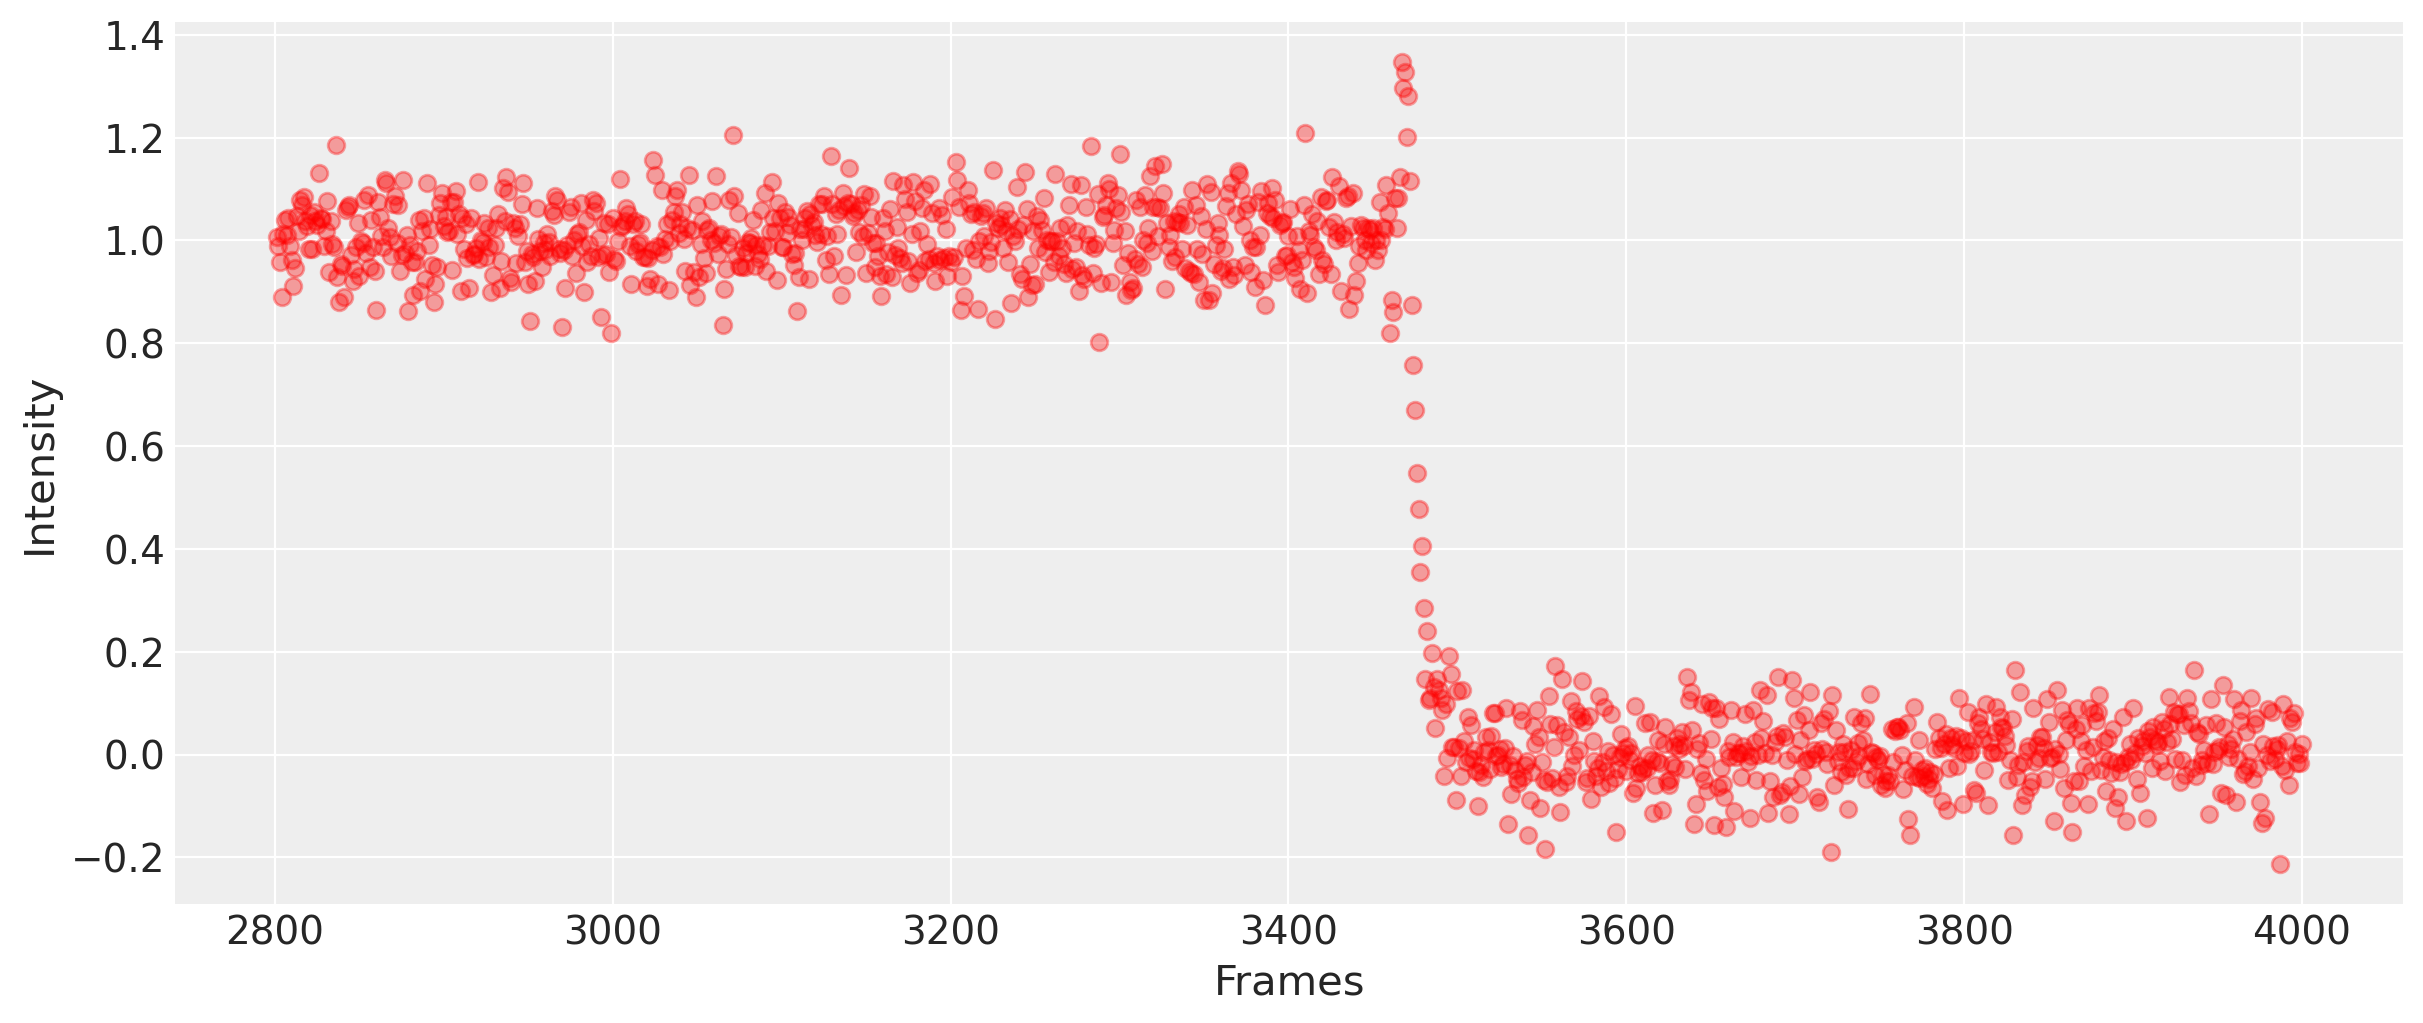

In [31]:
plt.figure(figsize = (12,5), facecolor='w')
plt.scatter(x_data, y_syn_scaled, marker='o', c='r', alpha=0.35)
# plt.invert_yaxis()
# plt.xlim(3300, 3700)
plt.xlabel('Frames')
plt.ylabel('Intensity')

In [32]:
@as_op(itypes=[at.dvector, at.dscalar, at.dscalar, at.dscalar], otypes=[at.dvector])
def t_fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(-w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T)/den) * y
        y0 += y_new
    return y0

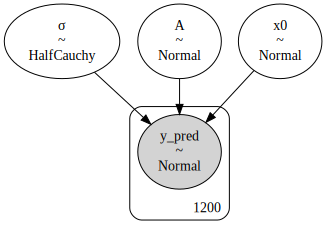

In [33]:
x_shared = aesara.shared(x_data)
d_shared = aesara.shared(d_moon)

with pm.Model() as model_polikromatik:
    A = pm.Normal('A', mu=1., sigma=1.)
    σ = pm.HalfCauchy('σ', beta=1.)
    x0 = pm.Normal('x0', mu=3480., sigma=1.)
    
    μ = t_fresnel_polikromatik(x_shared, x0, d_shared, A)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=value_scaled)
    
pm.model_to_graphviz(model_polikromatik)

In [34]:
with model_polikromatik:
    idata = pm.sample(cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [A]
>>Slice: [x0]
>NUTS: [σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 266 seconds.


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x0'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

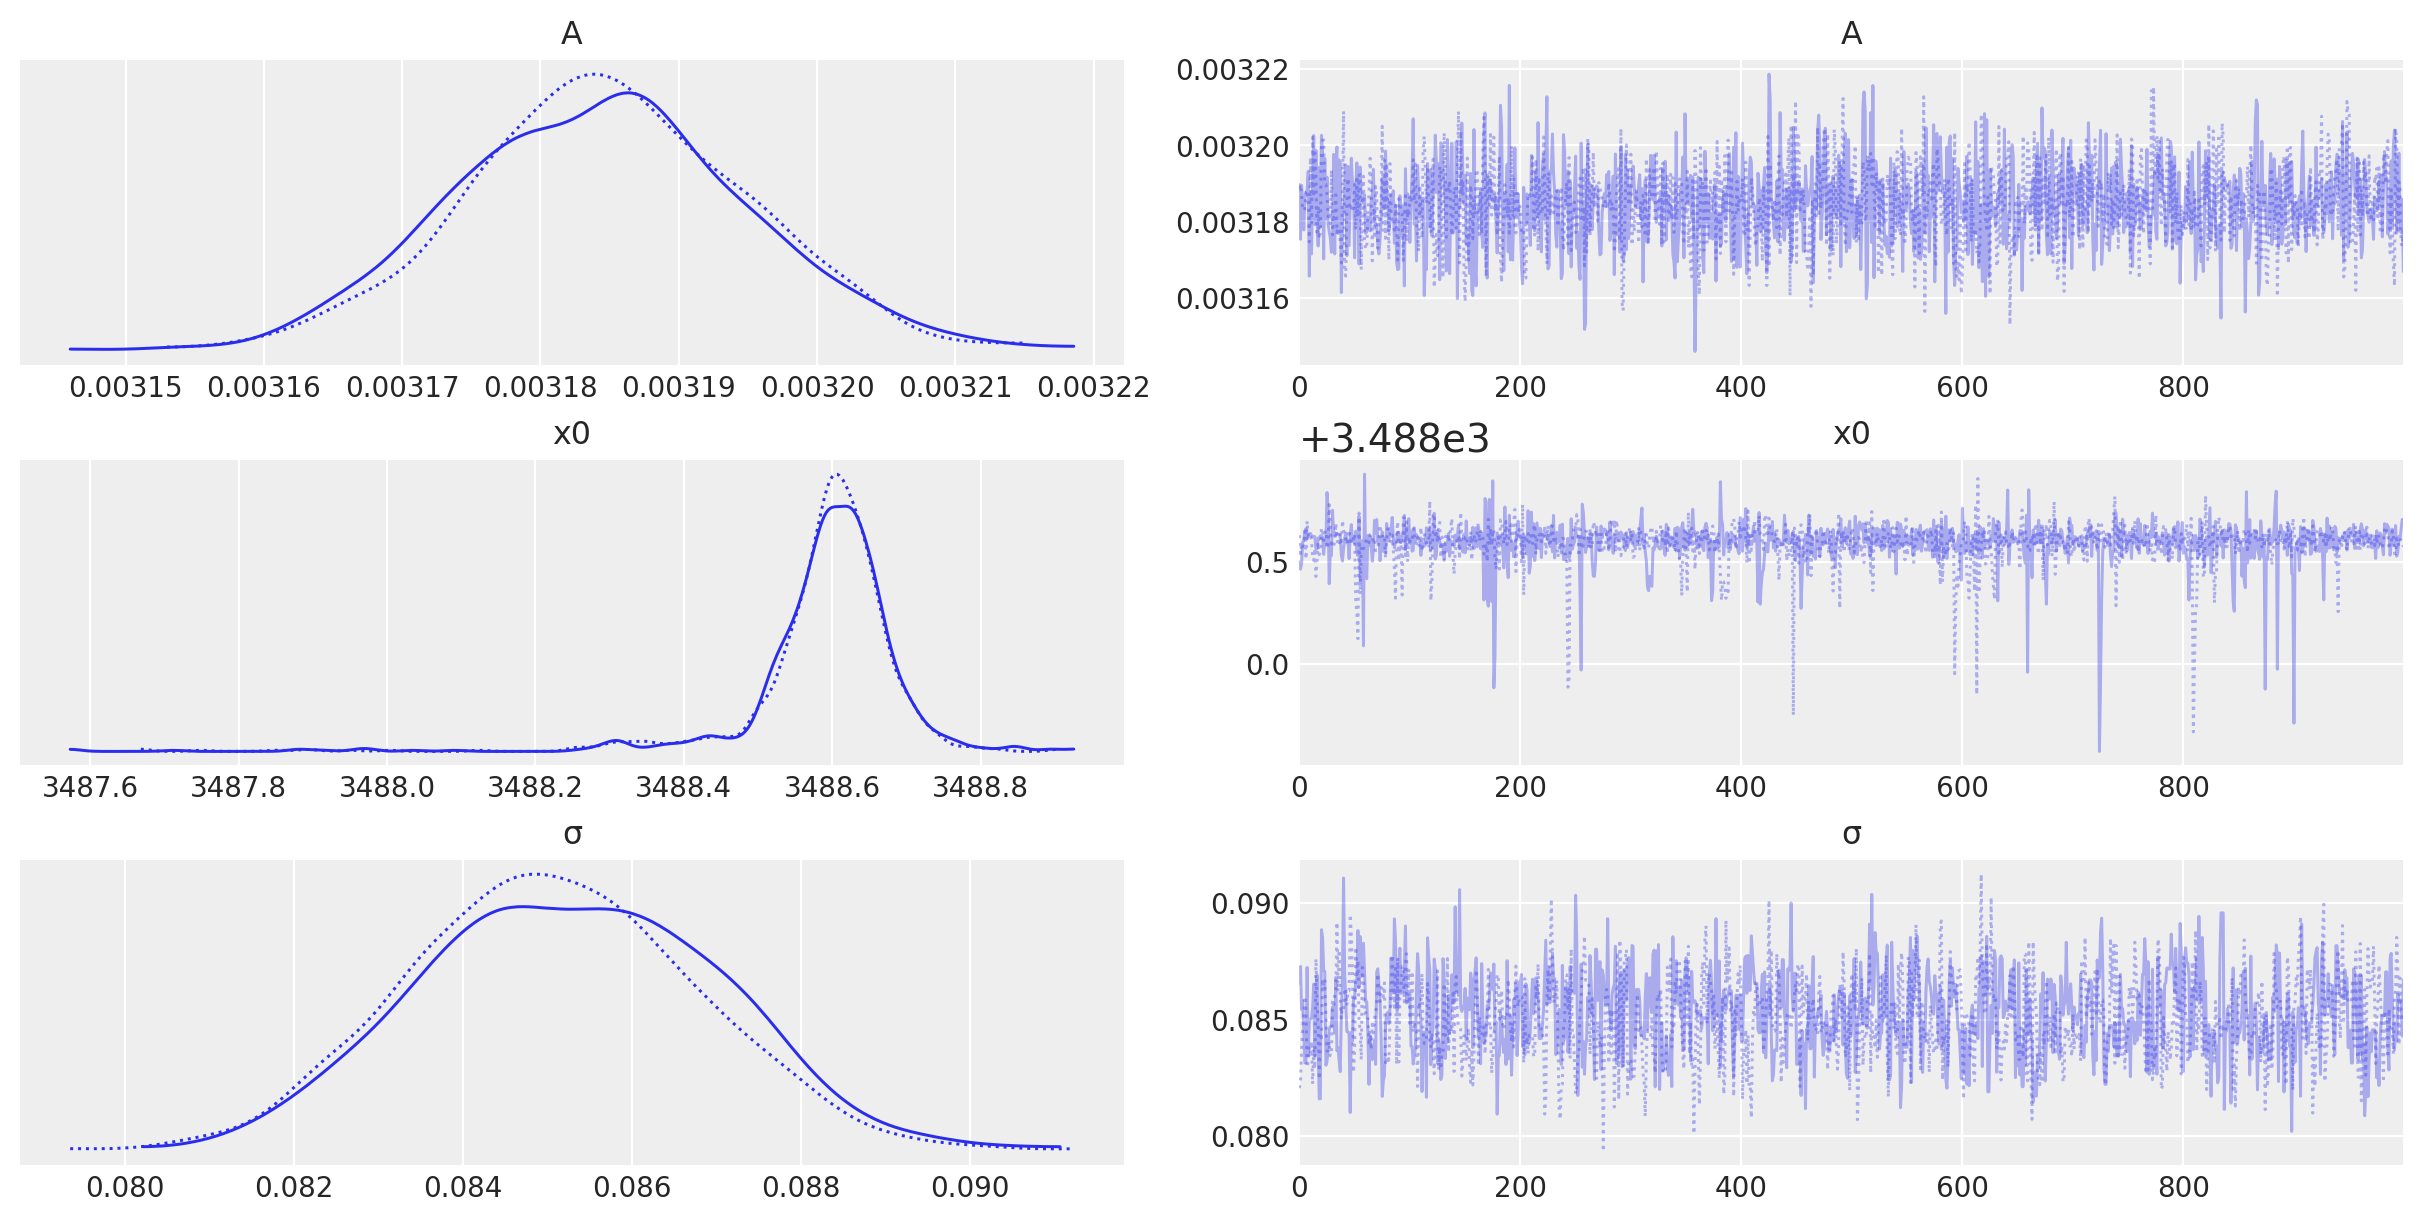

In [35]:
az.plot_trace(idata)

In [36]:
az.summary(idata)

mean    sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
A     0.003   0.0    0.003    0.003        0.0      0.0    1902.0    1417.0   
x0 3488.592 0.103 3488.421 3488.742      0.003    0.002    1585.0     695.0   
σ     0.085 0.002    0.082    0.088        0.0      0.0     870.0    1393.0   

    r_hat  
A     1.0  
x0    1.0  
σ     1.0

In [37]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [38]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Median

C:\Users\User\AppData\Local\Temp\ipykernel_14688\803455705.py:9: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


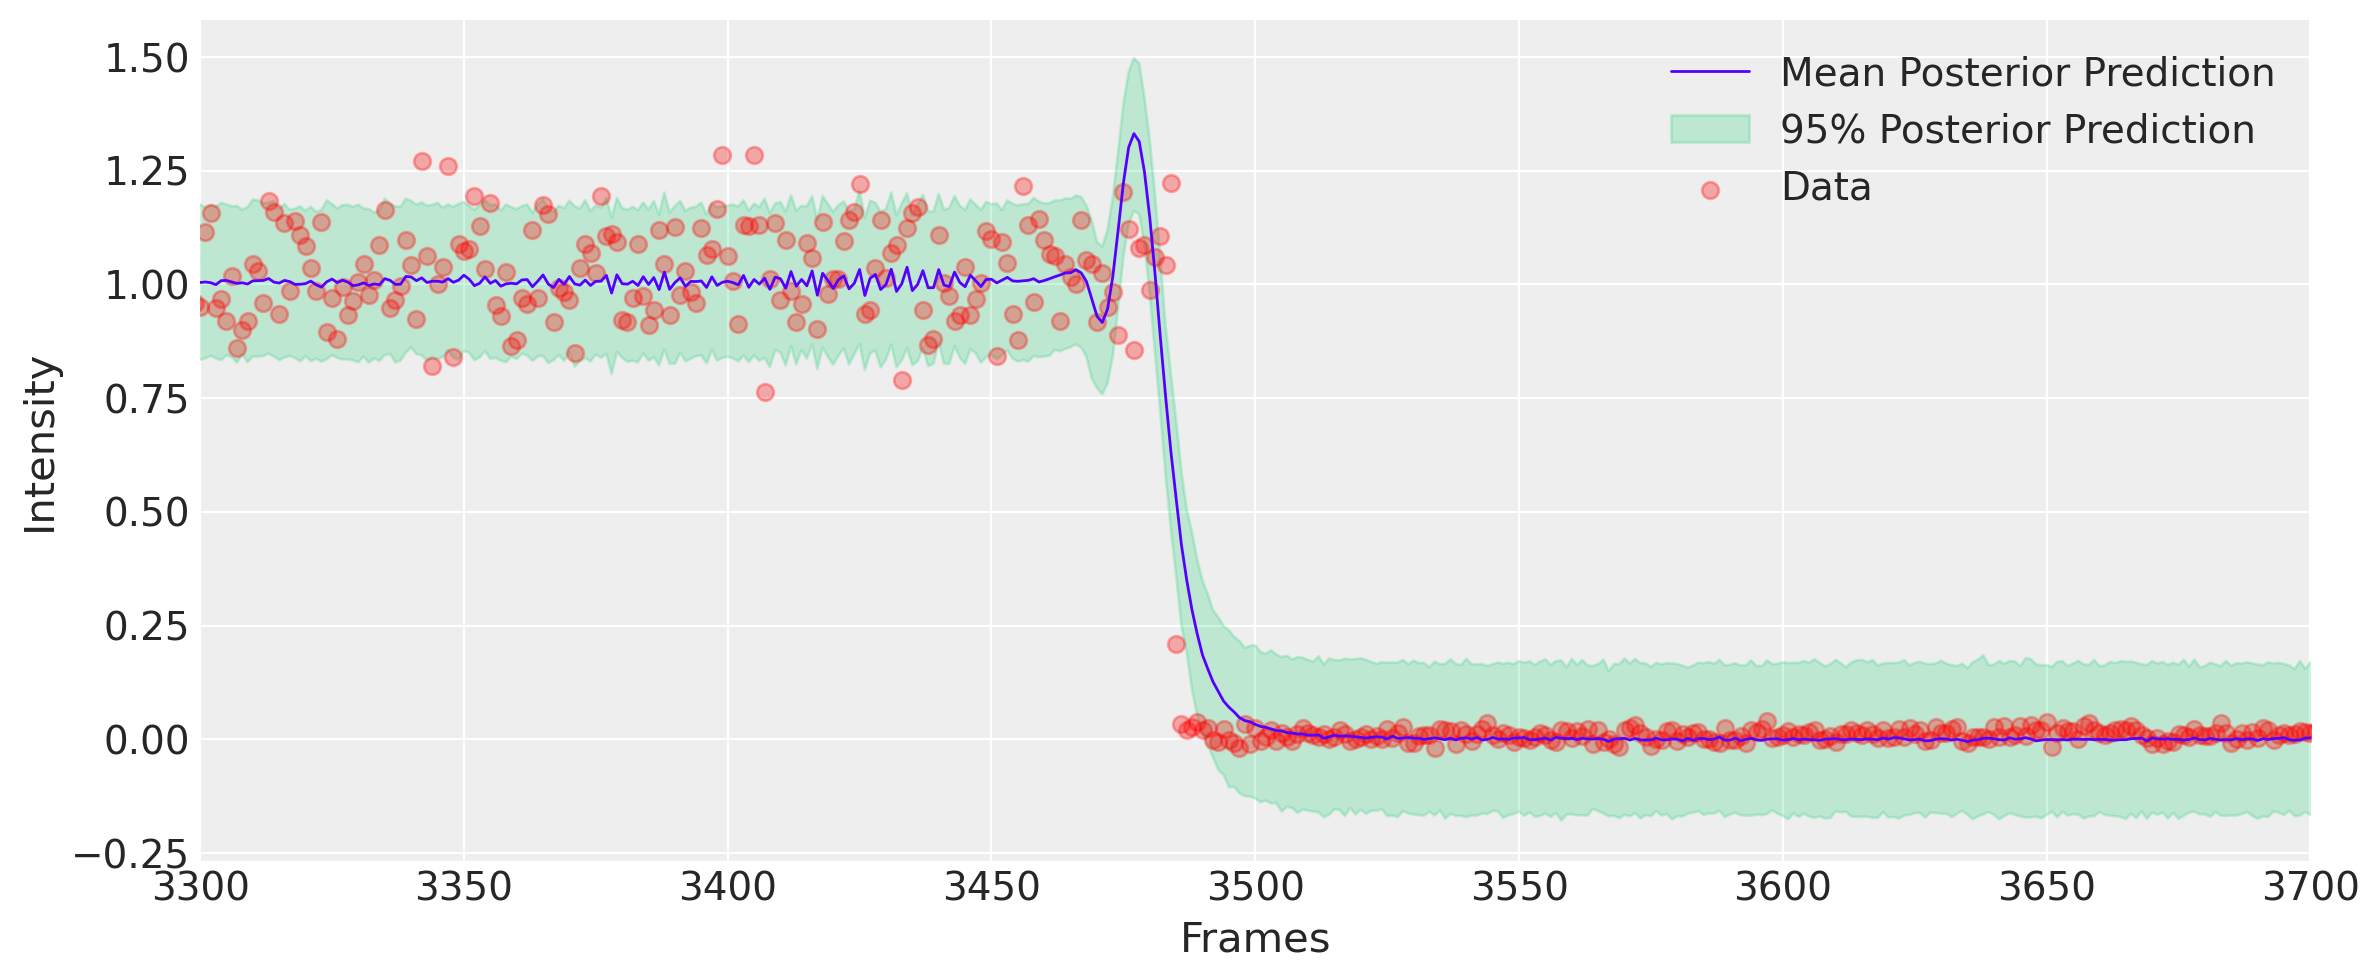

In [39]:
plt.figure(figsize=(12,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data, value_scaled, c='r', marker='o', alpha=0.3)
# plt.plot(x_data, y_data, 'r-', lw=1, alpha=0.5)
plt.xlabel('Frames')
plt.xlim(3300, 3700)
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Data'], loc='upper right')
# plt.savefig('hasil-kurvatransmisi-planck.png', dpi=150)

### *Data smoothing*

In [40]:
from scipy.signal import savgol_filter

In [41]:
y_filtered = savgol_filter(value_scaled, 10, 2)

(3300.0, 3700.0)

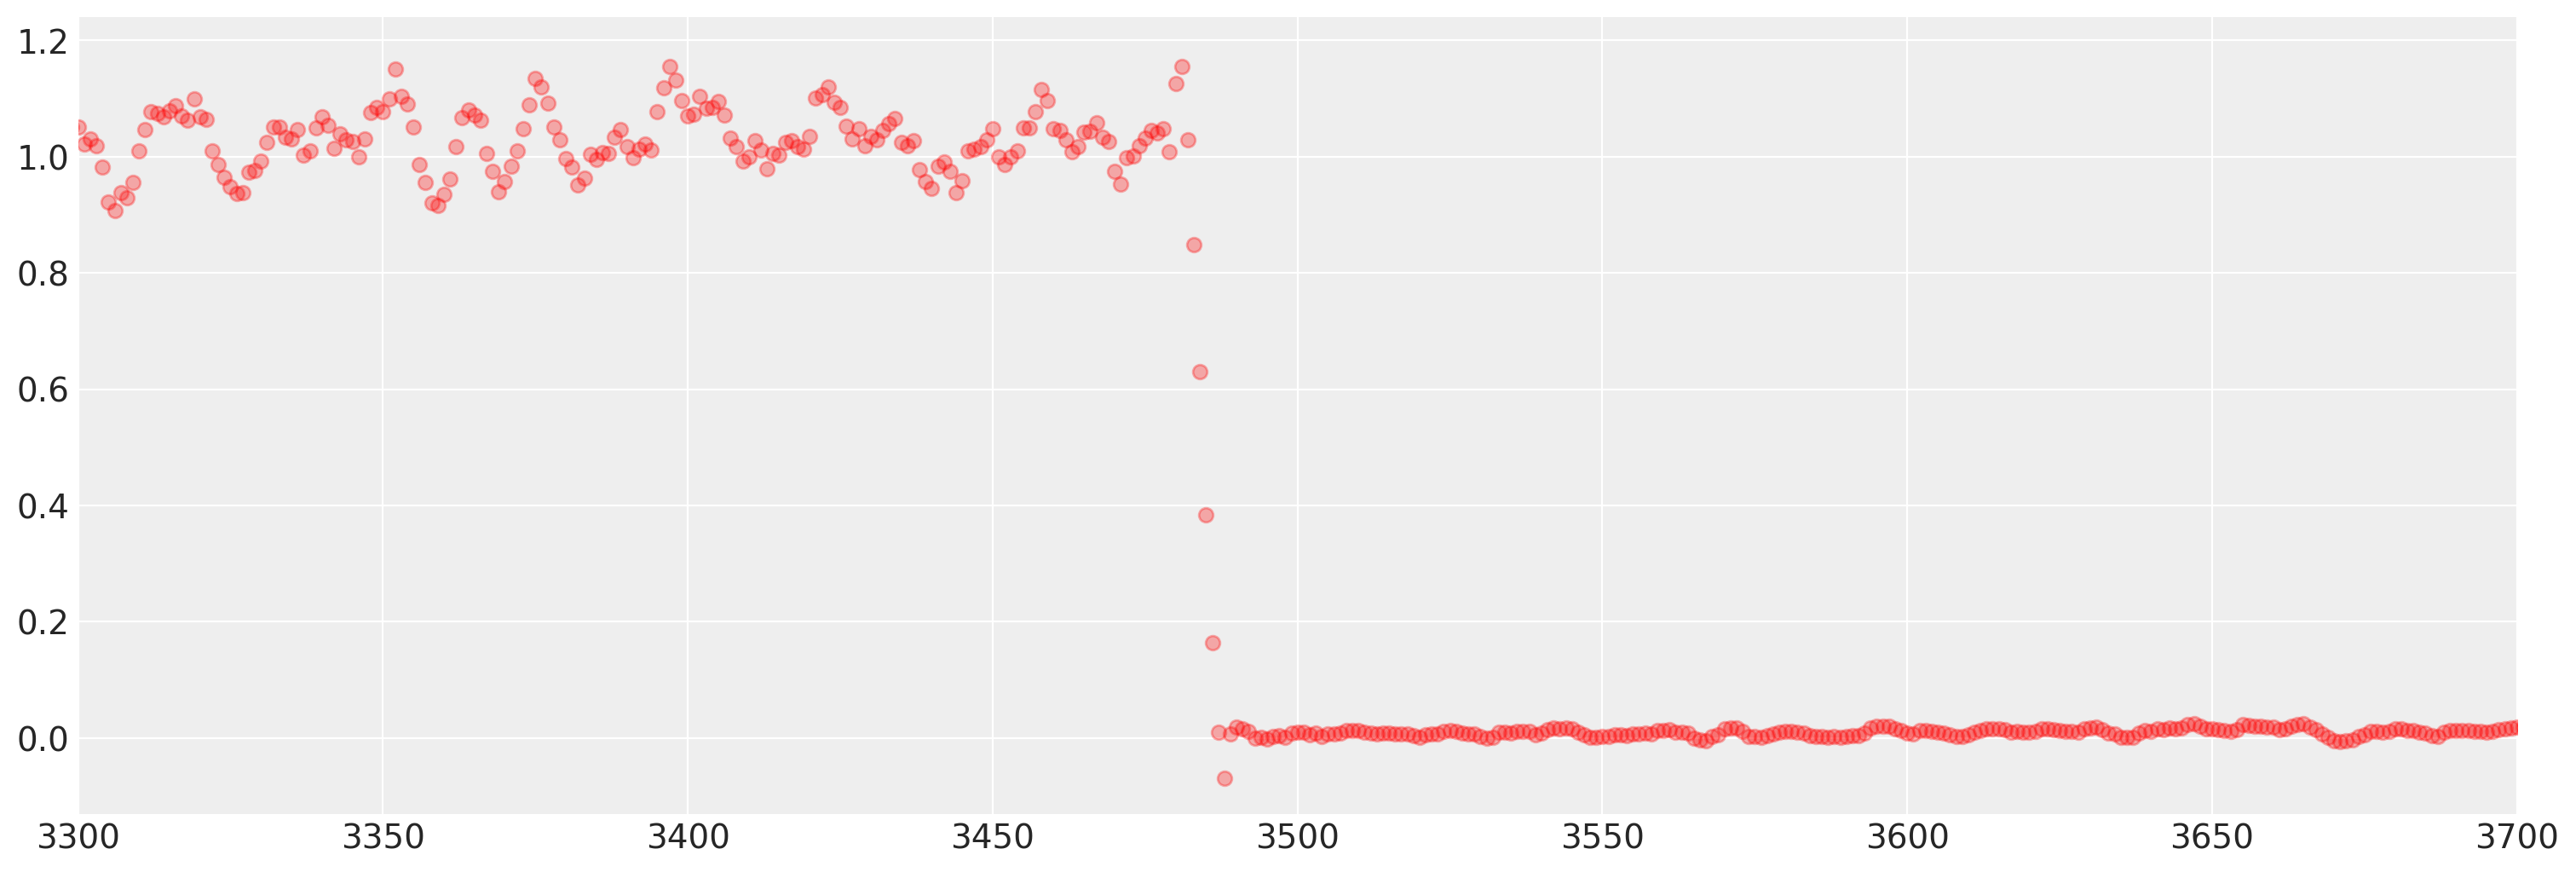

In [42]:
plt.figure(figsize=(15,5))
plt.scatter(x_data, y_filtered, c='r', marker='o', alpha=0.3)
plt.xlim(3300, 3700)

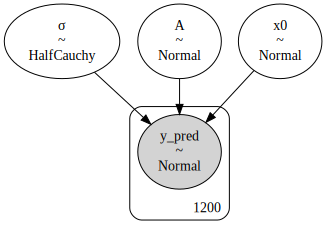

In [43]:
with pm.Model() as model_polikromatik_smt:
    A = pm.Normal('A', mu=1., sigma=1.)
    σ = pm.HalfCauchy('σ', beta=1.)
    x0 = pm.Normal('x0', mu=3480., sigma=1.)
    
    μ = t_fresnel_polikromatik(x_shared, x0, d_shared, A)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=y_filtered)
    
pm.model_to_graphviz(model_polikromatik_smt)

In [44]:
with model_polikromatik_smt:
    idata = pm.sample(cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [A]
>>Slice: [x0]
>NUTS: [σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 283 seconds.


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x0'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

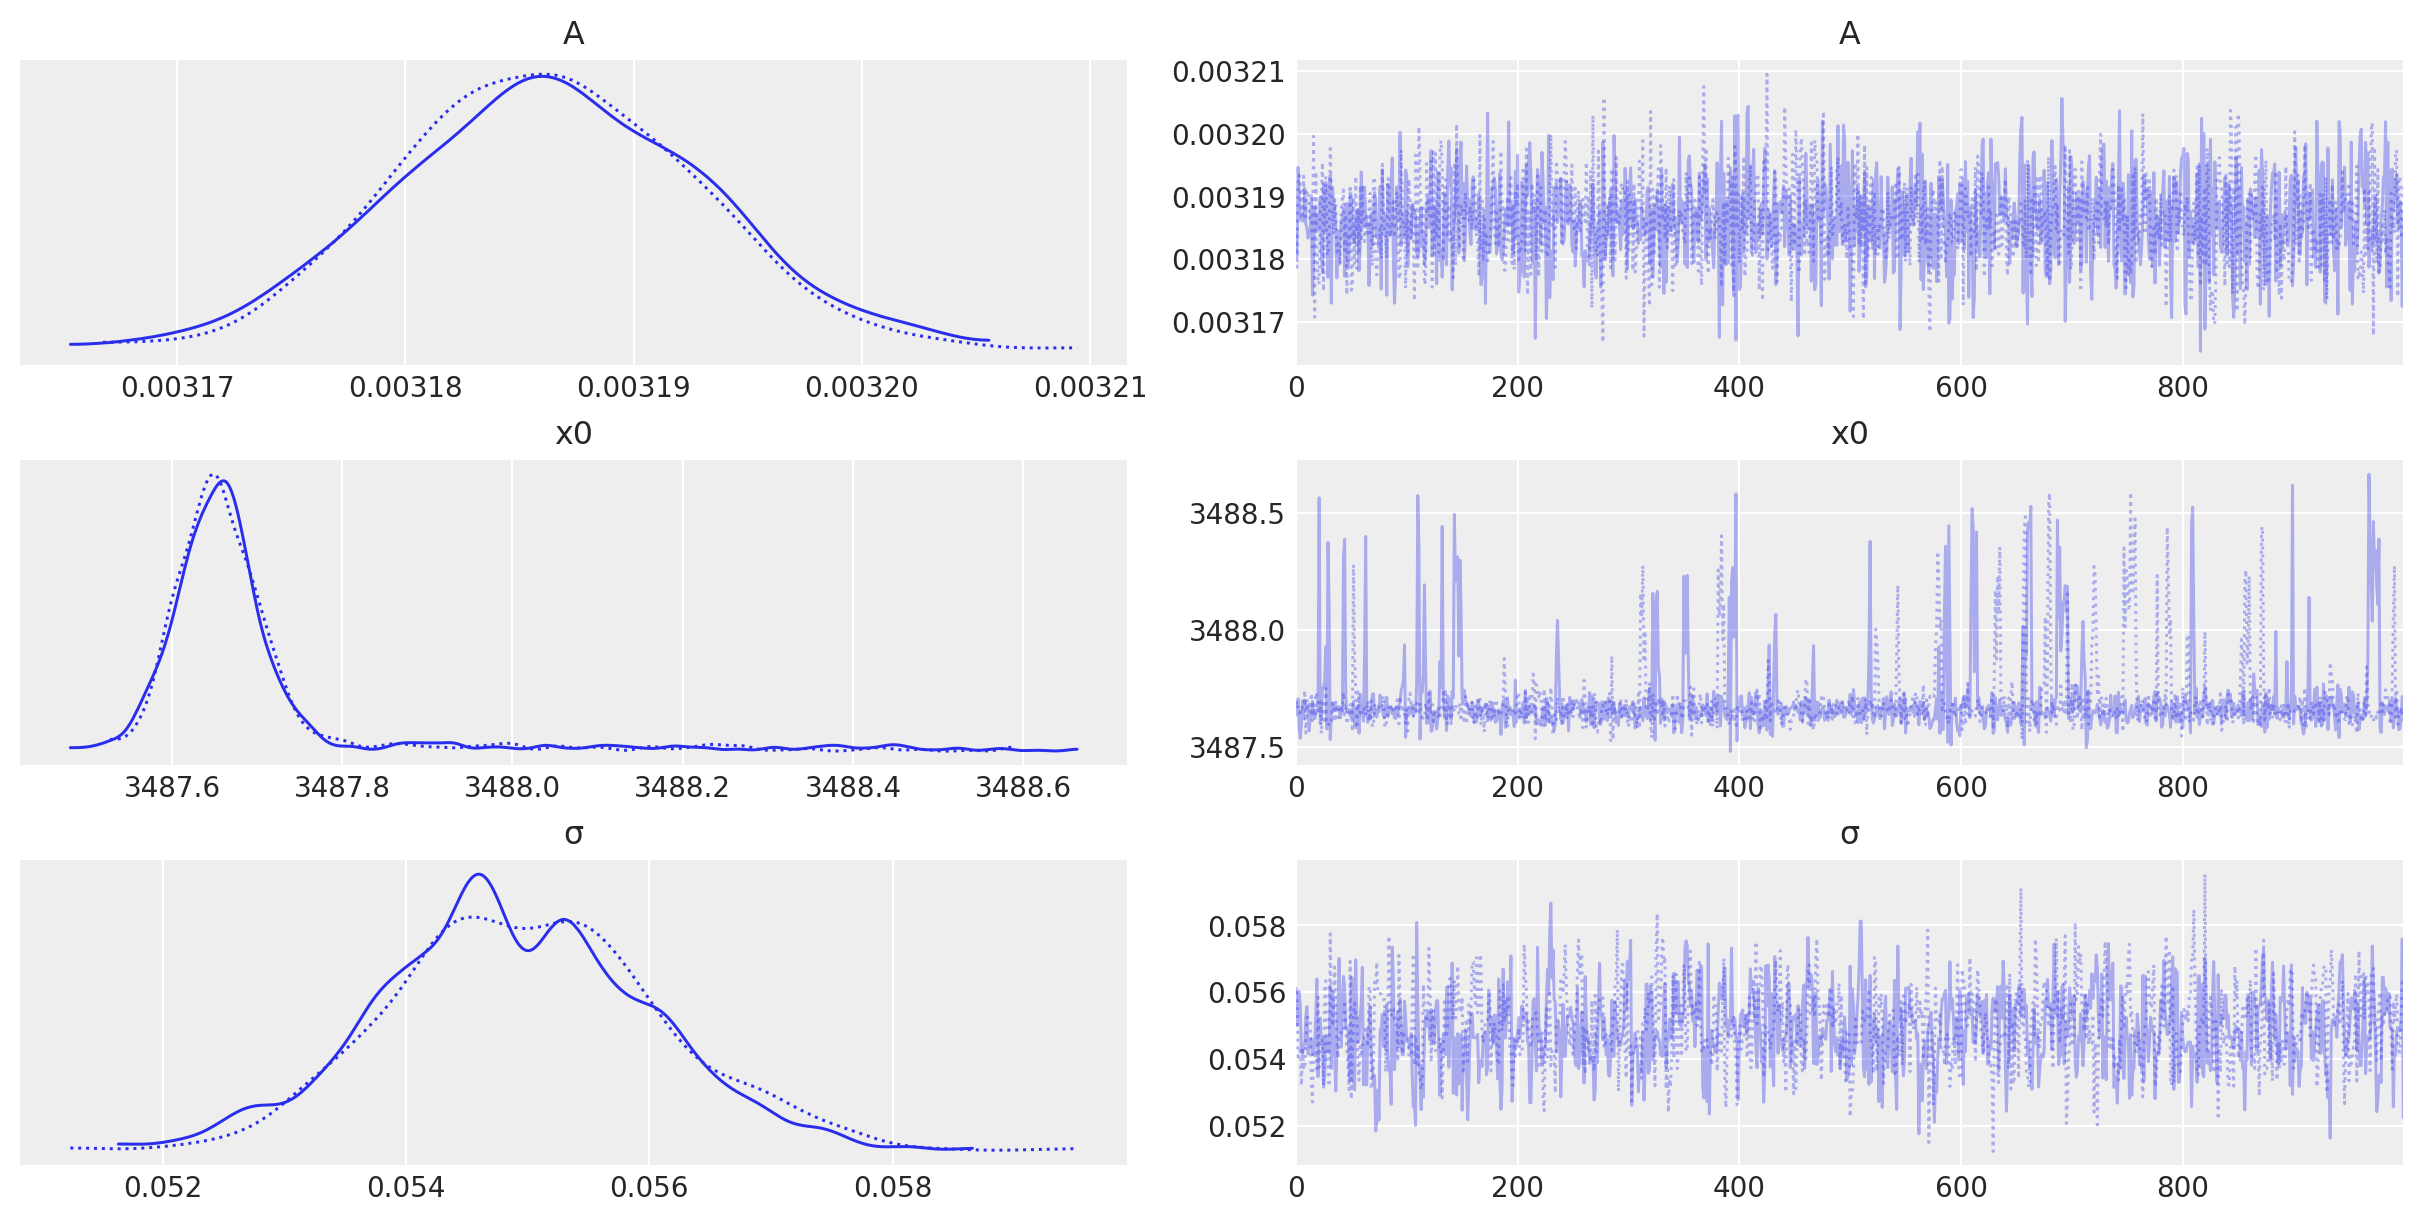

In [45]:
az.plot_trace(idata)

In [46]:
az.summary(idata)

mean    sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
A     0.003   0.0    0.003    0.003        0.0      0.0    2063.0    1461.0   
x0 3487.697 0.159 3487.524 3488.001      0.007    0.005     893.0     524.0   
σ     0.055 0.001    0.053    0.057        0.0      0.0     814.0    1346.0   

    r_hat  
A    1.01  
x0    1.0  
σ     1.0

In [47]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Median

C:\Users\User\AppData\Local\Temp\ipykernel_14688\2971269113.py:9: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


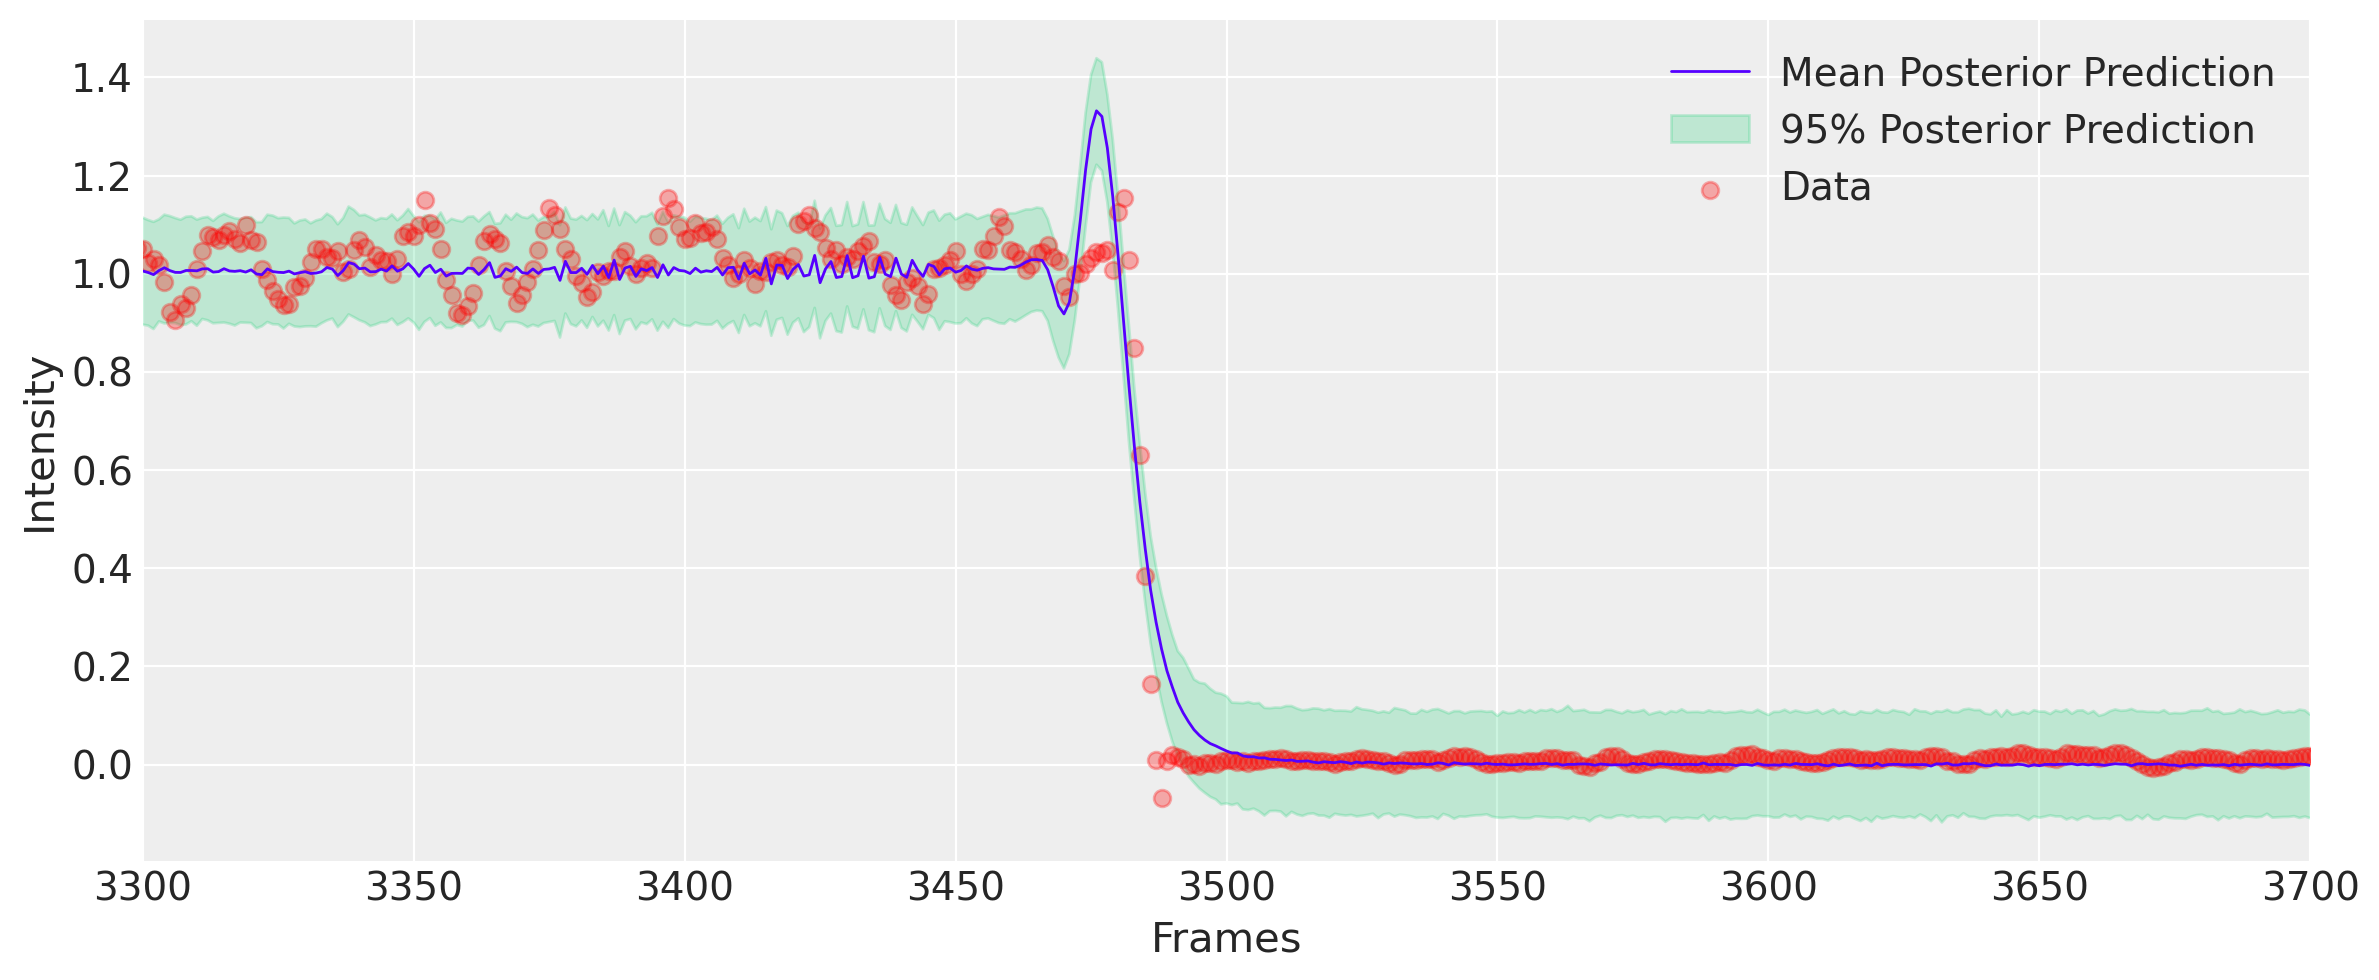

In [48]:
plt.figure(figsize=(12,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data, y_filtered, c='r', marker='o', alpha=0.3)
# plt.plot(x_data, y_data, 'r-', lw=1, alpha=0.5)
plt.xlabel('Frames')
plt.xlim(3300, 3700)
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Data'], loc='upper right')
# plt.savefig('hasil-kurvatransmisi-planck.png', dpi=150)

### Konversi *Frame Number* ke waktu

Text(0, 0.5, 'Julian Date')

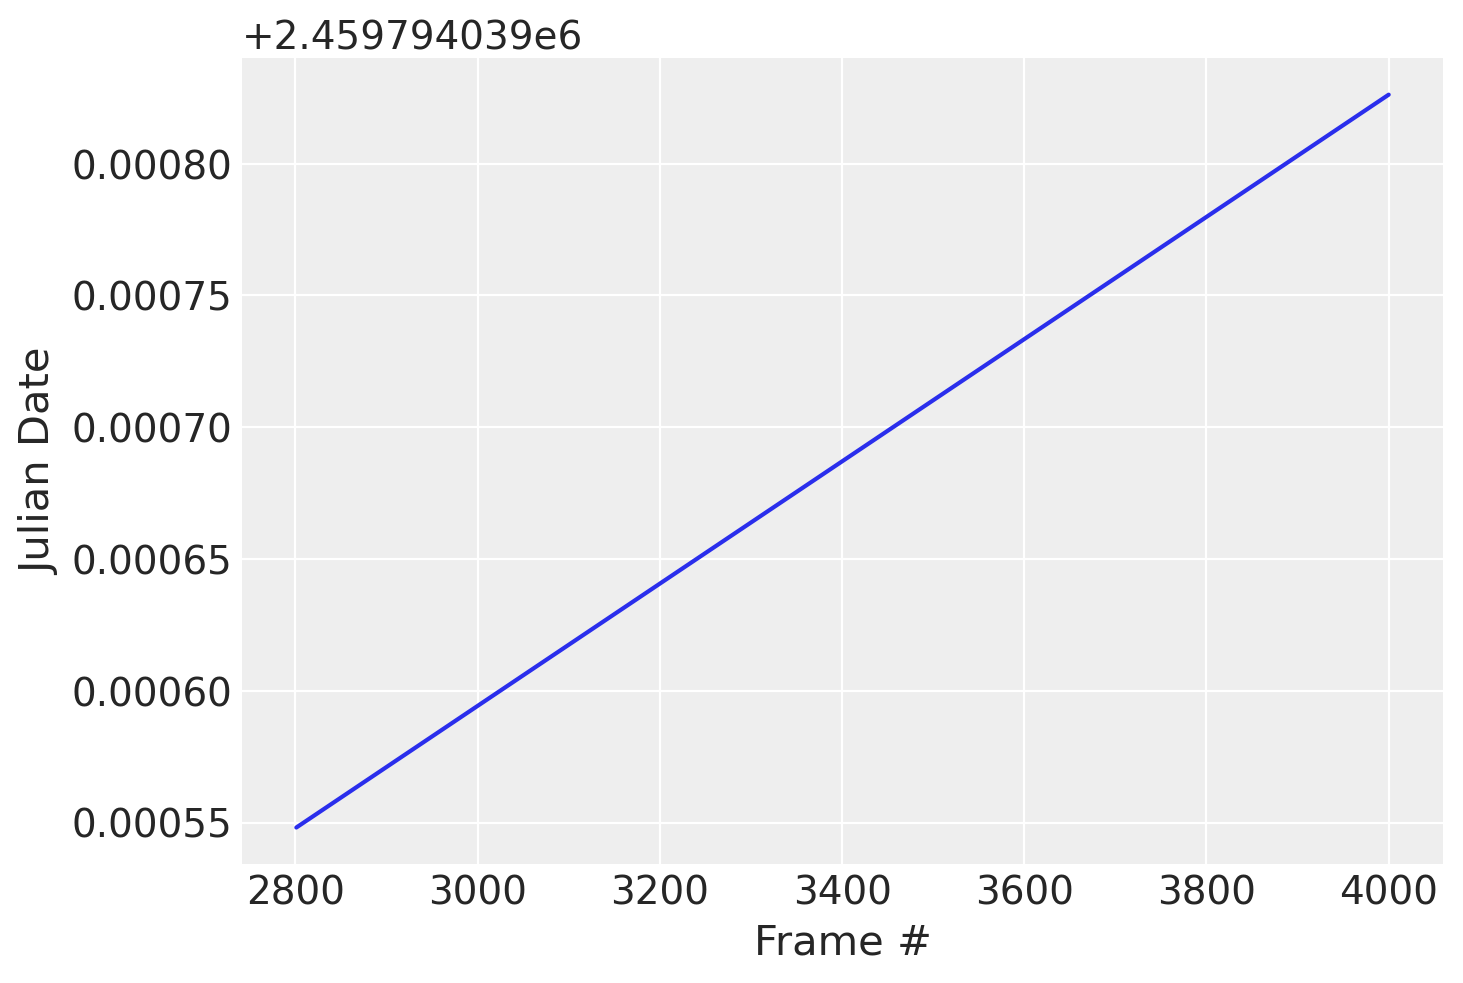

In [49]:
x = data['Frame']
y = data['JD']

plt.plot(x, y)
plt.xlabel('Frame #')
plt.ylabel('Julian Date')

In [50]:
f = interp1d(x, y, kind='cubic')

#### Ambil nilai dari `arviz inference data`

In [51]:
framenum = idata.posterior.mean().x0.values

In [52]:
# interpolasi

date = f(framenum)
type(date)

numpy.ndarray

### Ubah `ndarray` ke `str`

In [53]:
date_str = np.array_str(date)
date_str

'2459794.0397073813'

In [54]:
# Ubah ke format waktu

j_date = Time(date_str, format='jd')
# j_date.value
iso_time = j_date.iso
iso_time

'2022-08-02 12:57:10.718'

In [55]:
data.dtypes

Frame             float64
Time       datetime64[ns]
Value             float64
JD                float64
frac_JD           float64
dtype: object

### Ubah `str` ke format `timestamp`

In [56]:
t_iso_time = pd.to_datetime(iso_time)
t_iso_time.time()

datetime.time(12, 57, 10, 718000)

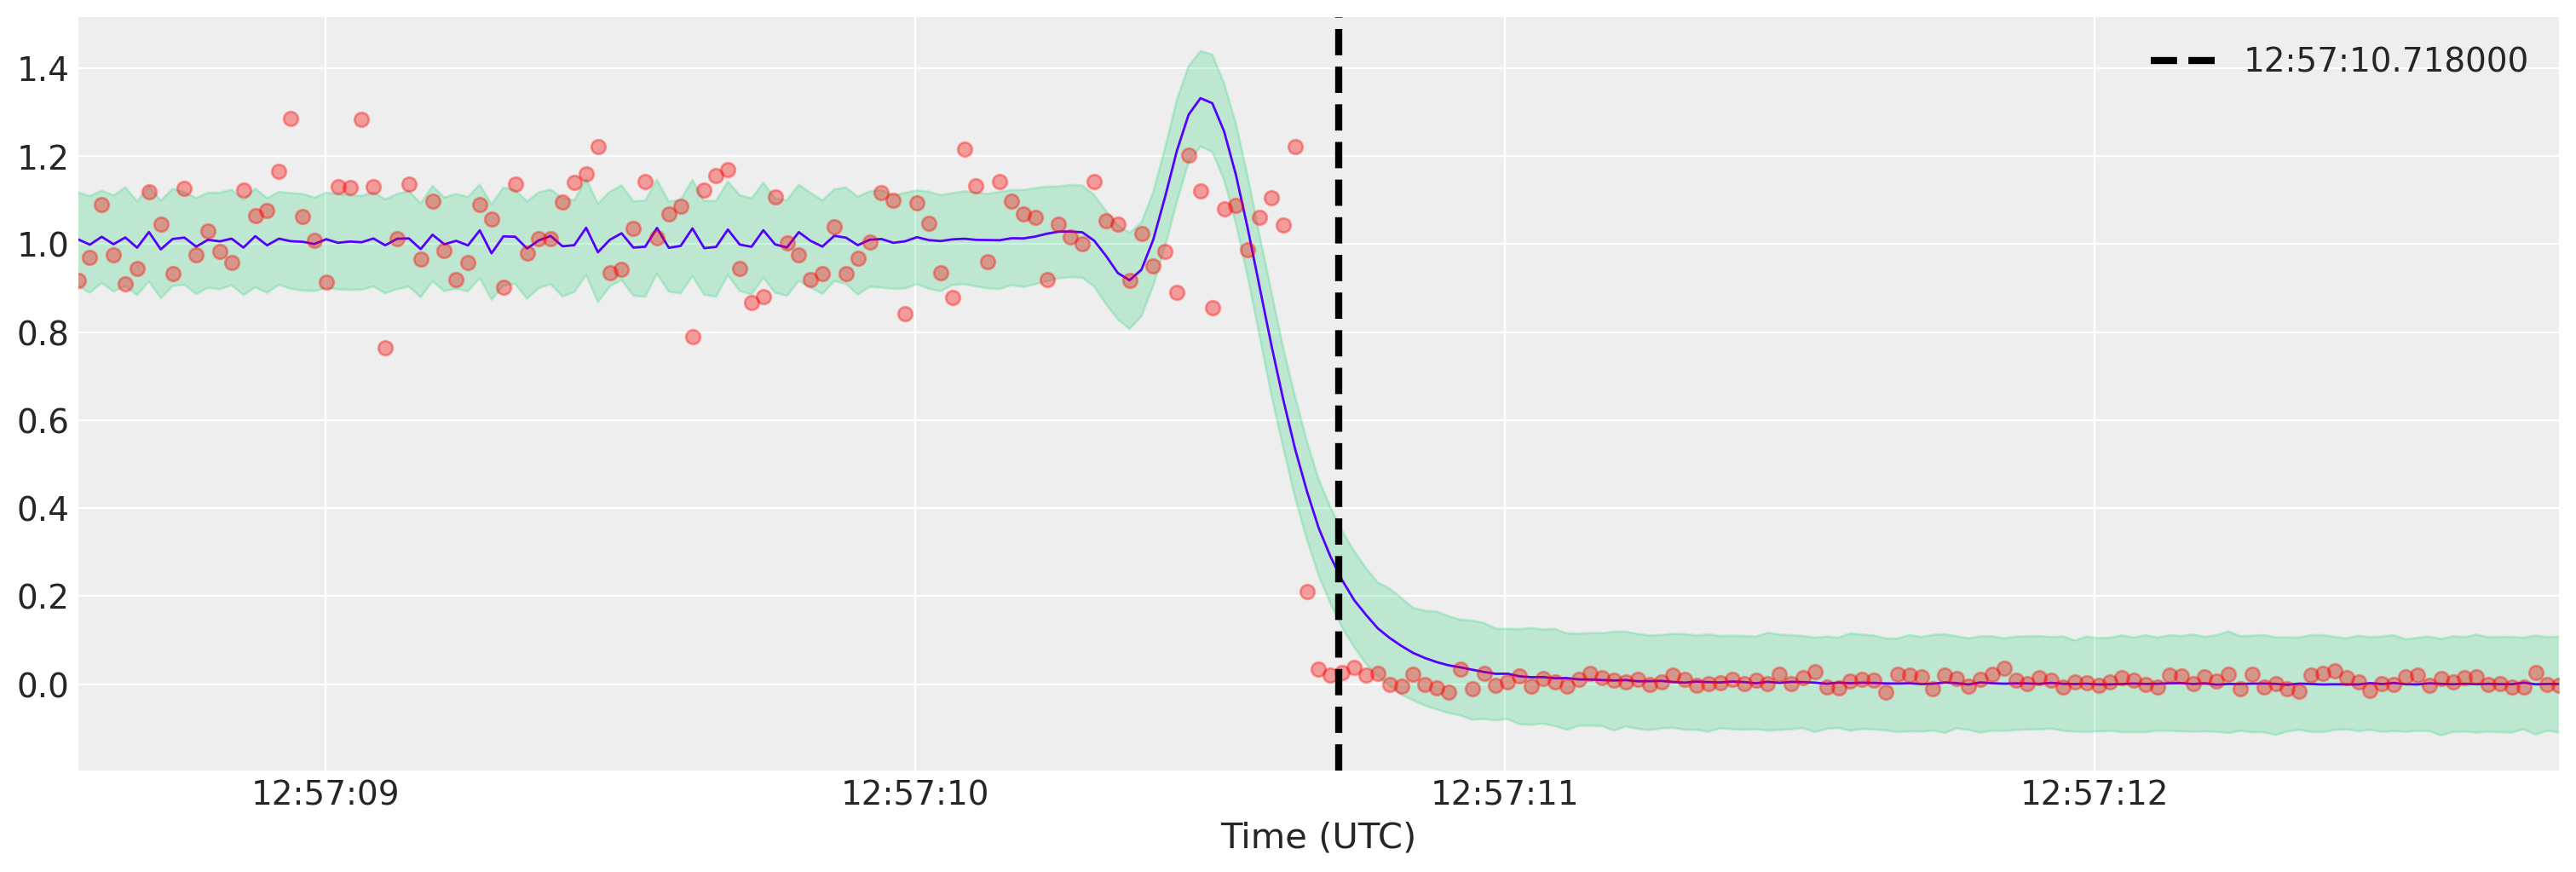

In [57]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(data['Time'], mean_spp, linestyle='-', linewidth=1, color="#5500ff")
ax.fill_between(data['Time'], crit_l, crit_u, alpha=0.2, color="#00cc66")
ax.plot(data['Time'], value_scaled, 'ro', alpha=0.35)
# ax.plot(data['Time'], y_filtered, 'ro', alpha=0.35)

plt.axvline(x = t_iso_time, color = 'k', lw=3, ls='--', label = t_iso_time.time())
plt.legend(loc = 'upper right')

#ax.plot(data['Frame'], data['Value'], 'ro', alpha=0.35)
# ax.set_xlabel('UTC (mm:ss.ssssss)')
ax.set_xlim(data['Time'][580], data['Time'][790]) # baris ke-# untuk kolom 'Time'
ax.set_xlabel('Time (UTC)')

date_form = mdates.DateFormatter("%H:%M:%S")#, tz=pytz.timezone(‘Australia/Sydney’))
#ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
#ax.xaxis.set_major_locator(mdates.HourLocator(byhour=None, interval=2))
ax.xaxis.set_major_formatter(date_form)
# ax.tick_params('x', labelrotation=45)

# data['Time'].dt.hour()

<AxesSubplot:xlabel='y_pred / y_pred'>

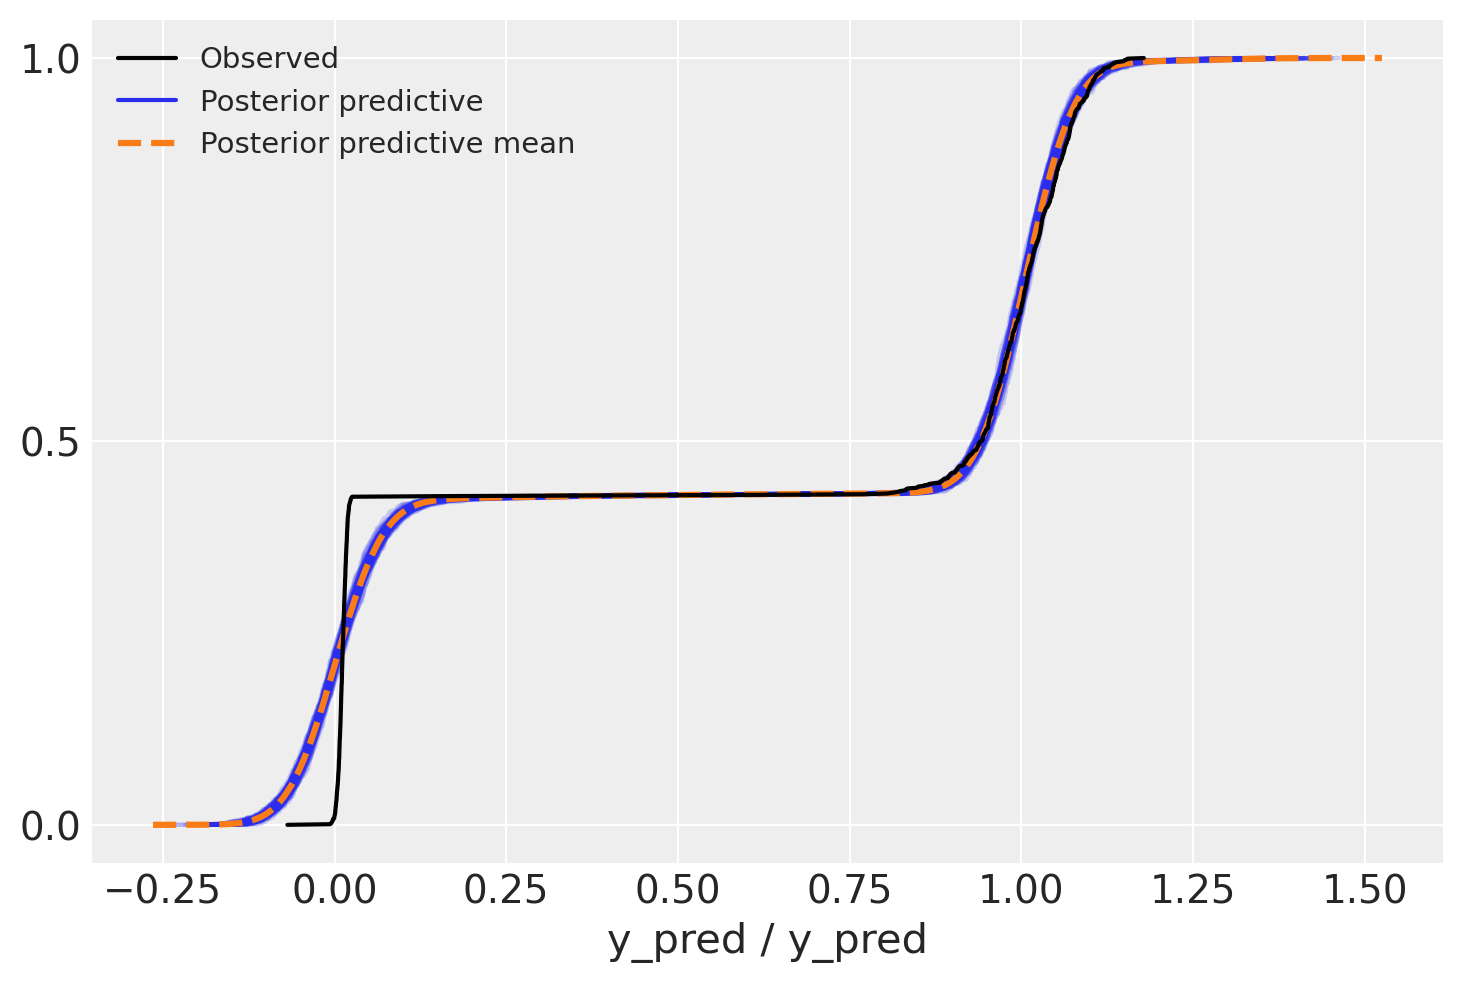

In [58]:
az.plot_ppc(idata, num_pp_samples=100, kind='cumulative')

<AxesSubplot:xlabel='y_pred / y_pred'>

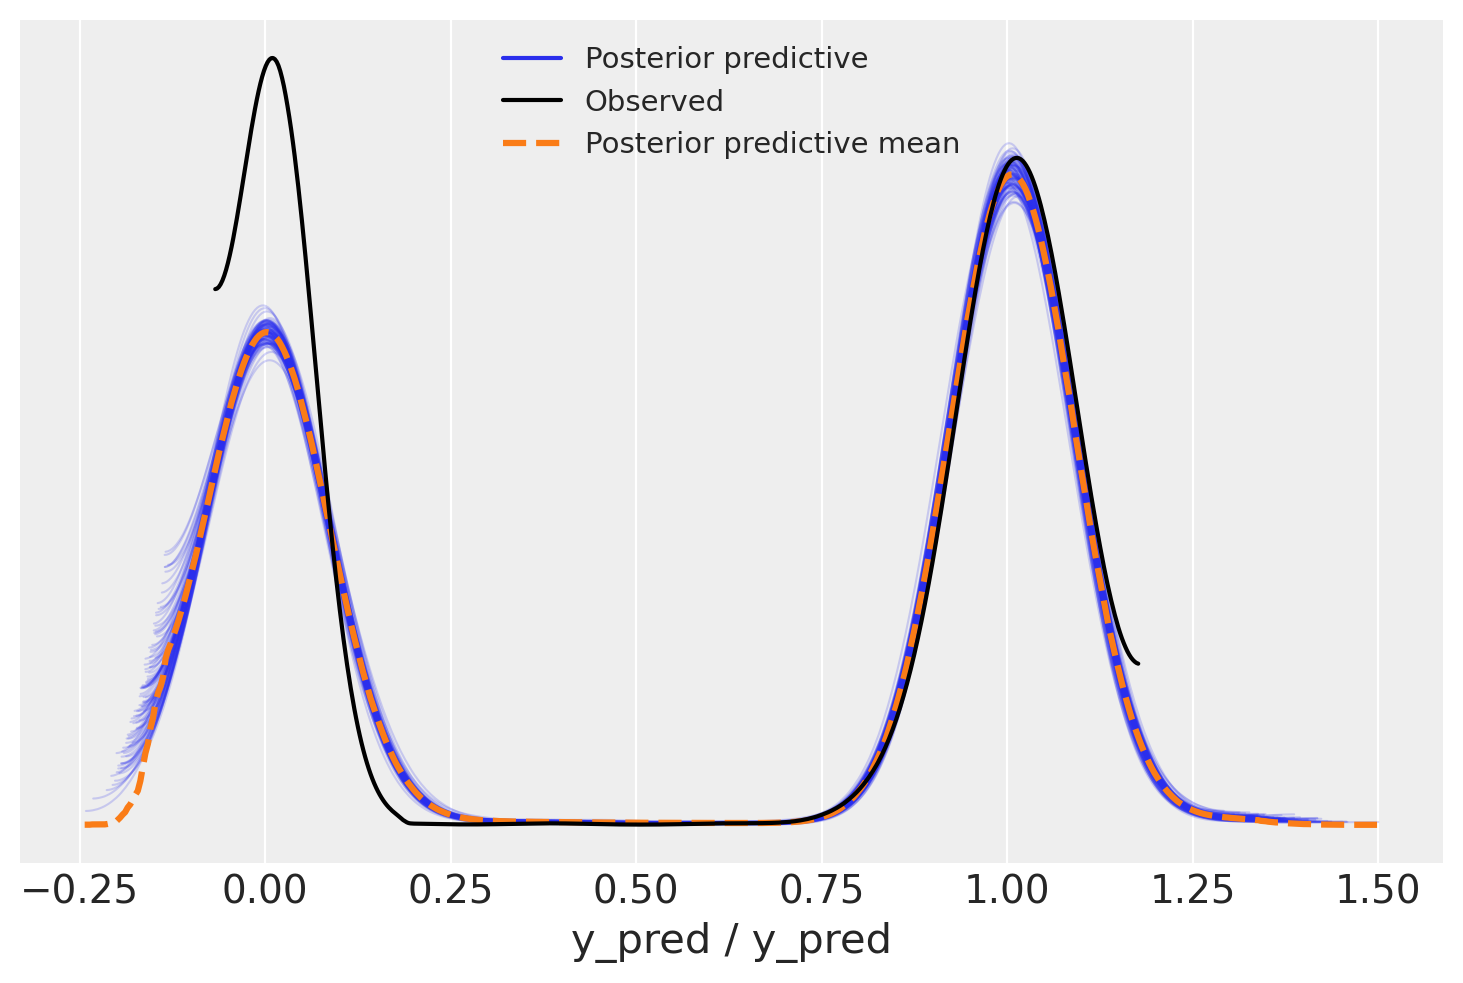

In [59]:
az.plot_ppc(idata, num_pp_samples=100)